<a href="https://colab.research.google.com/github/opencoca/disco-diffusion/blob/main/clip_interrogator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Interrogator by [@openco](https://github.com/opencoca/) and the [Startr](https://startr.ca) team

Part of the AI Art Startr Kit.

<br>

What do the different AI Artists see in an image? What might be a good text prompt to create similar images using guided diffusion or another text to image model? The CLIP Interrogator is here to get you answers!

<br>

If this notebook is helpful to you please consider buying us a coffee via [Buy me a Coffee](https://www.buymeacoffee.com/) or following us on [twitter]() for more cool AI stuff. 🙂

And if you're looking for more AI art tools check out our [site](https://startr.ca).


In [1]:
#@title Setup

import IPython
import time

display(IPython.display.Audio(url="data:audio/wav;base64,UklGRjzGAABXQVZFZm10IBAAAAABAAEAQB8AAEAfAAABAAgAZGF0YRjGAACAgIGBgYGBgYCBgICAgYGAgICAf39/f3+AgICAgICAgICAgH9/f39+f39/fn5+fn5+fn9/f39/f39/f39/gICAgIGBgICBgICAgICAgICAgYCAgICAf39/f39/f39/f39/f39/f39/f39/f39/f39/f35+fn5+fn5+fn5/f3+AgICAgYCAgYGBgoGBgYGBgYCAgH9/f39/f4CAgICAgIGBgH9/f39/fn9/fn5+fn5+fn5+fn9/f3+AgICBgYKCgoGBgYGAgICAgICAgIB/f3+Af35+fn5+f35+f39/f39/f39/f39/f4CAgICAgICAgIB/f39+f39+f39/f4CAf3+AgYGBgYGBgICAgIB/f4CAgICAgH9+fn9+f39/fn5+f3+AgICAgICAgICAgICAgIB/f39/f39/gICAgICAgICAgICAgICAf39/f39+fn5+fn9/f3+AgH+Af39/gH9/f4CAgICAgICAgIGBgYGBgYGBgYGBgYGBgYCAgH9/fn5+fn5+fn5/fn5/fn5+f39+fn9/f39/f35+fn5+f35/f4CAgICBgYKCgoKCgoKBgYGBgYCAgICAf35+fn5+fn59fX19fn5+fn5/f4CAgICAgIGCgoKCgYCAgICAf39/f35/f39+fn9/f3+AgH9/gICAgYGBgYGBgYGAgIB/f39/f39/fn5+fn9/f35+f35+fn19fX5+fn9/f39/f3+AgICAgYGBgoKCgoKBgYGBgYGBgYGBgoKBgYCBgH9/f39/f39/f39/f35+fn5+f39/f35/f39/f4CAgICAgICAgICAgICAgH9/f39/fn5/f39/f3+AgICAf4CAgICAgICBgICAgH9+fX18fHx8fH19fn5/f3+AgICAgIGBgYGBgYGBgICAgIGAgICBgYGBgoKBgYGBgIB/f3+Af39/f4CAgH+Af39/gICAgIB/f39/f3+Af39/gIB/f3+Af4CAgICAgIB/f39/f39/f39/f39/gICAgH9/f39/f39+fn5+fn5+f39/gIB/f39/f39/f39/fn5+f3+AgICBgYKCgYGBgIB/f39/f4CAgYGBgYCAgH9/f39/f4CAgIGBgYGBgICAgH9/fn5/f39/f4CAf39/gICAgICAgYGAgIGBgYGAgIB/f35+fn5+fn5+fn59fX19fX19fn5+f3+AgICAgICAgICAgYGBgYCAgIB/f39/f39/f4CAgICAgIGAgICAgH+Bf4GBfYGAfYCAfn+Af36Af4CBgICBgYGAgH+AgH+AgIB/f39/f39/f39/gICAgICAgICAgH9/f39/f39/f39/f39/gIB/f39/f39/f39/f39/f39/f39+fn1+fn5+f4CAgIB/f39/f35/f39/f3+AgICAgICAgYCAgICBgYCBgYGBgYGAgH9/f4CAgICAgIGBgYB/f39+fn5+fn5+fn5+fn9/f39/f3+AgICAgICAgYGBgoKCgoKCgoKCgoGAgIB/f39+fn59fX5+fn5+fX19fX19fn5/f4B/gICAgH9/f39/gICAgICAgIB/f4B/f39/fn5/f39/f4CBgYGBgoGBgYGBgICAgH+Af4CAgH+Af39/fn5+fn5+f35/f4CAgICAgICAgICAgICAgICAgICAgICAgYGBgYCAgICAgYGBgYCAgH9/fn19fn19fX1+fX19fX19fX1+fn9+fn6AgH+AgICBgIGBgYCAgYCAgIGAgICAgICAgIB/gICBgICBgYGBgYKCgYGAgIB/f39+f39/f39/f4B/f3+AgIB/f39/f3+Af3+AgYKCgYCAgIGAgH9/f39+fn5+fn5/f4B/gH9/f3+Af39/f35/fn9+fn9+foB/f39/f39/f359f39+f39/f4CAgYGAgIGAgYGBgYGAgYGBgYGCgICAgYCBgIGAf4CAf3+Afn9+f3+Afn9/f4B/f4B/gIF/gIB/f4B/gIB+f39/gIB/gIGAgYCAgYB/gH9/f39/f39/f39+fn5+fn1+fXx9fX19fn5+f35/f39/gICAgIGBgYCAgoCAgoGCgYGBgYGBgYGCgYGCgoCAgH9/f39/f39/fn9/f39/gIGBgIB/fn9+fn1+fn5+fn5+fn9/f36AgICAgYGBgoKDgYCAgH+AgICAfn19fX1/f39+f39/f39/gIGAgIF/fX9/gH9/gICAgICAgYCAgICAgICBgX+BgYGBgICAgICBgIGDgYGAgIGAf4B/foB/f39/f39/fn5+fX59fX9+foGAgIGAgYCBgYGAgIB/gH99fn5+f35+fn5/f35/f35+f39+f3+Bf4CCgIGBgIGBgIGBf4CAf4B/gIB/f39/gIB/gIGBgH9/gH9+f39/f35+f35/f31/gICBgIGCgoGCgYGAf39+f39/gICAgIB/f39+fn5+fn5/f39/gH5/gH5+f35+f3+BgIGBgYCAgICAgIF/gIB/gICAgH+AgX+BgoCAg3+AgX+Af3+Bf35/gH9/f35/f4CBgX+Af39/gIB+f39/f39/fn5/f39/fn9+fX9/gYGBgYGBfoCAf4B/gH+AgYCAf4B/f4B/fn6AgH6AgH+Af39/f319f3t7fX59f4F/gYB/gYB/goGBgoGBgoKBgIGBgYGCgoGCgoGBgX+Af35/fn5+fXx9fX1+fn1+fn9/foCAf4CAgICAgIGAgIGAf4F/fn9/f39/gIB/gH9/gICBgICAgYGCgoGBf39/fn5+f4CAgYGAgYF/f4B/f359fn19fn5+fX19fX1+fn+BgYGCgYKCgYKCg4WFhIWFhYOBgH98enZycnR0dHR2en1/gYOEhIOCho+Ul5ydmZKGfXp3dHNzcnBubGhpaWdoamtyfIWIh4ibtaqdm5GSkoGAjpORhnh4em9pYWRsaWRkYWJlYmt7i5ynpaeuopKDd3V7goiXpaSdjXxyaGFiZmhramZlYF1dXmRxhqW7uratnY97ZWFrfpamra2mknhiWFpmbnBwb3BsZGBlY2ZrcYCryLmxqJiUgWBecYOZpqanoY1uVVBaaXBwbnBtZV1YWl9mbX2r0tHEsaCYgV9TYXmYo6W1sJV3UUFVYGl5fH13aGJeWl1eYW16l83axbulj4ZmS1dthqGor7mlf1pASF5odYKHhXNkZWFdXVlfc4Ou3c6/uZeGeE5GYHKPp6S2vZd3W0ZXZ2Z3hIaFcGRtZmBfWGF3grDfysC7k4FxREFebY2morK7lXNcRlFiX3GGjI9/bnVzaWZeX215hcHgwcCtgHtjNUBdbZamm6+4m3pZRlpoanuLm6ONd3VwbWlXVmJueZbOz7+7jnNwTzhKWneeoaO8upd2V0thaWyCmKeojXVzbWFZTk1daXKHvNbAup58e2dHSVhmipyYprSqknZdX21uc4OSm5eDdG5lWldVWmpxd4SguK6noZCQinFjZmZyf3x+jZmZlYyDh4l/dnuAhoV2bnFycXV2fYmHgoOChoV8d3Nub29xfIeLjJKSko+Efn58e39/gYqNiYiDfHt3cXF1eH6DgX99end0bWtvdHyDiI2RkouFfnp9e3d7foOLjIyPjIV/dnN6fn+BgYGAfXh1c3J0dn2Dh4uLiYeFgX58fHt9f3+EiImJh4F/fnx9gIGFiIWEhIGAfnl5fH5/f4CDhYWDgH16eXZycnV4fX+AgH99fX59fX+AhIiKiYiHhoeEf319foCAgYSFg4B+fHx7enl6eXd1dnl5eHh6e31/gYWIioqIiIeFg4KBgIGAgoOCg4WHiYeDgX97dXJxdHh5enx+f359fn9/f36BhISFhYSFhIB/fn5/gYWJiomGgn99enp7fIGDgYF/eXd1c3N1dnl9gYOEhYWEgn16enyEgYCLjIuKhH9+gIGBhYaGh4WBfnl1c3JxdHd3en5/gYJ/gIB9fH2Ah4qNkZCPjIt/eX9/e32Ag4iEfHl/fXZzdXV2e3l+h4SDg4F+e3d5eX2Dg4WIiIaGgYCCfHh6eHt/gIiJhIN+e316eX2AhIaBgIB6dXh2en9+goSGiIeEhoOAfnl3eXp9gYGCgoCAgH17gICChYOEhYKAfnt7fHx+gIKGh4aFhIF/fH1/f4KDgoB/fn58enp9f4GBgIKBgX99e3l2dnh4e35+gYODhISDhIaIi4yNjouHhIB/fXl4eHh3dnV3eXp4dnh2d3p5eXp5e315eXt8jJiJmqqdoJmPlI14dXNmaGJeaGttfoaKl5KXnY+RkoaEfnZ7cGdqaG50cXd8dXZ2b29uZWlsdodwjbKaqbW1saqTkZJxcW5mZWdkbnNugIKEh4qNjIiEjH96fHNwbGtzeHmFhYeMh4qKgICAd3VzbW5rZ2ttcH6Kg5m0o665rqSaiHlzW1paVVxkZWp2eYWLkpqgpKGfm5SIhXtwb2trbWxxd3d6fHt/fXt6d3RybWprZmdobHmDiJmopq+2raSfloqEeXN0bmloZmJla253goiOk5OTk4+RkY6Mi4uHgnx4dnNxcG9ucHBubm5ucXJzdXRxcnBub3B0fYWNo6yyvbq0sKWWkol/fnZsZV5STUlHUFpkc4OPl5qbn6Cfnp2cnJaOiIJ8d3NwbW1raWtra21ram1ubW1ramxtb29yeoOUm6u+vsnIu7Ool4yFd3JuZF9cUk1QTVJeZnWEjJObnJ2dnJ6fnp6alI+EfHRtaWVjZGRlZ2xxdHV4eHZ1dHN1dXR2eXl6eHh9go6UpLG1v723sKaXi4RzbGZaVVNNSE1MVGFpd4WPmKGjpaimpKOempWLhX53dG9sbWpoa2lqbnB0d3d3dnV0cnN0dXh6fH5/gYKDhoqSlqOtrbWzp56RgHVvY2BkXl5iXV1jZWl2gYyaoKOnpqKgm5STkIqGfndwamRfXFxfYWdscXZ7gISIh4aHiIeIh4eHgn19enZzb2xpam51f4eZpKevrKWgl4qCgHh1eXNxcmxna2xwfYSJlZuampaNiIB4c29tbW1raWhrbG9ydnyCh4yPkpOQjYiCfnp1cnJydXZ2eHl5eHd1dHN0dn2IipSqp6a2sKCdmoiBhnhxeXNnaWxeYGtlbXp9gYyMhYuNgYGCfH+CfH6Ffnl/eXN6fH2DhYOHhoSEenN5eHJ1e3t7e31/fn+DgoKEgIF7dnt7eZaMda2tfZmviXySf2B1c1hve2p0i4F9komCj4t+g4p3dHx0cXRydn59g4+Sj5WSi4V8dnJva210dnV5fH1+gYWJiYeHg315dHJuamtwc3V0foKBhYqLpbaBj76Kc5WSfoSMeHuHbmt4dXB2hYSGhXl7cWZmZnF3f4WRmI+QkI+HhYeHiIV/fHhtampudXx+hImEgoF7dndzcHZ2c3uAgIeOjpCUko+IhYOCdG93mKZjbJ95YnR1e42bfXagiGV0cXN/ioaJppWCfndubGxscYSJeYKAenl2eIeQjI+SjIWAd3N3dnR5f3yAhIGHjIqGiYeBfHt5eXdzbGtrZmVkaG51d4CZ18mAo6h3enppdKGpdXqQbmxoU16En4yMoZGMhWRicoR+eImIhYVtYW16fn2UjpSSdGpxenSFiYqMindzfnyCiI6MkY5/enp2cXNubG9vcHFzc3p/eH2L0MZrjYheeX5pbqW/jYSKYXKBa2aAq6Wblm9peWldYXuLjZqBa3ZvZmdveoSWkoGGgnV1f36FmJaRjomBgoOAgoWAeHZua25wcnZ9fn6AgIGEhYJ8eXZycGp0jI2jr4aBgHB0e42OnbWhjoZrX2RvcXGLj4iOfWxoa3Nwe4mJk5OCdm5ub3aAgoiHhXp1eHuFjI+OkIuGhYWEhYeAfnt0cHF1d3t+fX19fXt8fH6Bg4N+foWLiomFhol/fHt3fIGDgoaIhIGBf3+ChIOGh4F+fXt1dnd2e357fX97eXl2cXN3d3d9f4OKhoB/gIF+f3+Dkr+9jpR1WWNvcWWJoJSgooBramZfbouBhJaMgXhuWVhscniKk5CVk4Z4dXVxf4yQkJGQiIV9c3N4fYGGi4Z9e3JsbW1zgYmMi4eBfn56en+Ag4WCf3t7e3t/goaNkY6QkYuIg353dnZzdHZzcXNycXJxc3Z8hYyTlJKRioWGhIOCgoKAfHd2d3R2fICDh4mHhYJ+fnp3en1/gIGDgIKGgoOEgYGCf3x7eXR1enl8gH+AgX+AgICChIaGh4aFhYJ/gYB/goSDhYWDhYaEg358fHt7d3Z1dXh1cnR1d3h6fH6Hjo6Qj4+QkI2GhoiEgX55c3BuZmZqam91dnt9foGEio6Pko+OjYqKhoKDgH1/fXp4eHR4gIGDiYqHhoJ7eXp3eHh4enx6eHp9fICFh42Pjo+Oi4aFg35+fHh1dHV0c3RwcXd4fH+Ag4aIh4mIiIqIiIqKiYeGhH9+enZ1dnZ4d3d4eHp5d3h6fYCDiIeIiomJiomHhoWDg4F+fnt6eXl6e3x8e3x4dHd5eXh7fHt/gX6Cg4KEjI2Kjo6Li4uGhYaBfX16eHh1cnN1dnZ4e3yChYaHh4aIioqHhIaFgYF9eXh4d3Z0dHR2d3d5e36AgYSEhYeHiYuKiYeHhoSBfn1+e3h5eHV2d3V4fX6Ag4KChYSCg4SEhoaIioiGhoaFhoeIiIWCf3t7dm9tbGxtbG1ucXZ1eH6BhoiKi4yPjo6QjoyKiYeEg4B7fX59fn19fX15dnZ1dHZ4eXyAgICEhYWHh4eIiYeFhYF9e3p4eHd2eHh3eHp8fHyAgIKDgYCDhIOCgoKEhoWBgoaGh4eGhoaDgH9/fHl3d3V2eHd5fH+ChoaGioqJiYmHh4aDgIB+eXh4dnZ4dnR1dnd4eHl6fX9+foGDhYWFh4eHiIeGhYaHhYWDgoGAfnt5eHd4eXl4eXx+gICAgH+AgoGChISBgoOAf4CAgIKFhYWEgoCAfHl4enx9fn17e4CBgIKGiIiGg4KCgH19gYKBgH16enp3d3l6fYB/fH1+fn6AgIOHhYWGhYODhIWFgoB/fXt5d3h2dnZ3eHd3eHx/goSGh4iIioqJiIeHiIaEg4GAgH99fX59e3p5eXl3eHh8fHp8fX6AgYGDhoiIiIiHh4aDgH+AgH59fn59e3h5e3t6e35/gIGBgYCAgYKDhIOEhIGBf3x7fHx8fX17e3x8e3t9fn+CgYCBgYCBgIGBgIGAgoSDgoOFhYSDgICAf359fHt6enp5enp6e3x+gIGBg4OGioiFh4mGgYGAgH+Af35+fn19ent+fXt8fX19fnt7fn9/gIKDhYaFhYaGgn9+e3p6eHh6e3p7fn6AgYKFhoODg4KBf318fX5/f39/f4CAfn5/gIGAfn5/fn19fX1+gIWHhoaGh4WGhoOCgH5+fHp6ent7e3x8f4B/f39/gIB/fn1+fX6Bf4CBgYGChYeJiYiHhYWGhIF/fXt6enl3eHd3eXt7e3x9fn9/gIGCgoGCg4OEhoSAgYB/f359fn5+fn5/fn+Af4CCg4KCg4GAfnx7fHt6e319fX+Af4CBgIGEhIODgoB/fXx7eXp8fX+BgoWHhoWDgoOBgYKCgoKBf358ent8fX5/gICBgX9+f4CBgoSDhIeHhIOCgIKBgICAfXt6eHd2dXR1eHp7fH5/goSEgoKCgoGBgX+AgoKCgoODg4ODgoKCgoKDgoB+fXx8fHp6e31+fn58fX9+f4KDg4OCgoCAgH+AgYKDgoF/fn59fH18fH18e3x9fX+Bg4SGhYODhIOCgoKBgYB+e3x7e3x9fX+BgYGCgoGAgICAf319fn+AgICAgH+Af319fXx8fXx9fX9/fn9/f3+BgoOFhISGhoSAf39+fn9+f4B/f399fYCBgYGCgoGAgH5/gH5+gYGAgH9+gIGAgIKBgYF+fHx8e3t9fn+AgIGCgYCAgICBgICBgYCBgX9/fn5+fXx9fX+AgYKBgH+AgYB/gIGCgoGAgYB9fn99foGBgYOCgIB/fnx/f31+fn5/f3x6e3x8fX5/gIGCgoSFhIODgoKBf319fn18fHx7fHt9f3+AgoOEg4ODgYKCg4KBg4ODg4KDhIOCgYGAgIB+fX58fHx8e3x9fH5/fn5/f3+Af35/gYKCgX5+fn19fn9/gYKBgYB+fn5+fn+Af4CAf39+foCBg4SFhIWFg4KBf3+Af359fXx8fHt7e3p7fHx8fH1+gIKCg4OBg4KBgYCAgIKBgICAfn6AgICBgYCAf319f3+AgYKCg4OCgoKCgoOCgoOCgIB/f359fHx7enp6enp5eXp7fHx8fX+AgYKDg4SGhIKDg4ODgoGBgoB/f39+fn59fHx9fX+Af4CBgX+AgICBgoSFhoaFhYSCgoF/f317eXh3d3d4eXt+f4CBgoODgoGCg4KBgYGBgoKBgYGBgoOCgYGBgICAf318fHt6eXl5e319f4GDg4OEhIODhIWFhIODgYB+fHt5eXh5enl6enp6fHx9f3+BhYWFh4iIh4eGhYOCgICAf359fHx8fHt7e3x+f4CAgICBgIGAgIGDg4KCg4KCgYB/gIB/f4CBgYF/f39+fX19fH1+fn5+fX19fn5/gYGChISEg4KBgYCAgH59fXx8fHt6e319foCBgoOEhISEg4KCgYGAf359fX5+fX1+fn5+fn1+f3+Af359fn9/f3+Bg4SDg4OCgICAgICAgH9+fXx7e3t8fH5/gIGCgYGDhISFhYWFhYSDg4OCgoJ/fXx7enp6ent7e3x7fHt8fX6AgYKDhIODg4OCgoKAf319fX18fH5/f3+AgICAf39/f4GBgICBgoKCgoKDhIWFhYSCgH59fXx8fHx8e318fH5+fX+AgYKCgICAf39/f4B/gH9+gIB/gIGAf39/fn5+fn19f4CBgYCCg4GCg4OBgYCAgICBgoKAf4CAf359fX18e3t6e3x9f4eDfH94dHuDiY2RjIB9enh9gYODhoN9e3l4eXx/gYWFgH18fX+BgoF/f317fX19gIOBf4B/fX9/fn+CgoCAgH5/gH9/gIKCgoODg4ODgoGDgoCBgYF/fnx7e3t7e3t7enl5enx+gIB/fn+AhIaGh4SAf399gI+blZKNdWZla3V/kpOHh393dHR5c3mIiI6RioJ4d3V0foKDhoaFfnl4cnJ1d3p5eXh2d3d3eHp/goCGhYeZq6mbkndeXGZ8iZiij4B2cG9ocXNtd4SQlZSUg3BwcnuKlpyUjYh/enl6fHyAgXt2cG5ucXl7d3NwbWxweH2BgICLoby3p5ZtVlJihpWorpeHdnJwYmNiZHOGnqeflH5oX2V2gomSlJCKhYB2cnl/goOBeW9udn6BgHhsYF9ncXuAgIGKrMm6p4plUEhqj5ytqJ+TgIJ7ZVZQX3aIoq6giXFnZGNtdn+KkJmXioB3dnl9hIR8c2tveH+FgnhtYWBkbXuCipSuybylhmNSRFd7kKCenp+Rin9rWEtWdZCgqqmYgHBubWhpc4WNj5KNgXRxeoCBgn13bmx0f4eDe3VtZGdwen+EmLvDsJh7bFlQZ3yPlZKfoJqPe2tXTFt0jJygm5GBdnJwbm10hI+Ri4R/eXZ6f4J+dnFvcHN7g4R7cm5tbnJ5i67HvaKFcWhbYW96h4aPnKGdhnBgV11sgJOcm5aSkIVyYV5uf4uQjod9dHN1eHl6e3l3dnZ4d3V2dnZ0cnWGrcrCpHtoZWBocICKhoyXpqeLbVlWYWx5iJObnJuYiXJdWWd5h4yLiYN7eHZ0c3J1e4B+end1dHN1fH17hqfEw6iDcW1qaWdwfIOLk6KpmHdbV2Vwc3Z+jpqhnI9/bWdteoWGgn15eHV0eHh3dnd7endxa2tyeX+Ck7PDupl5cG5wamVwfouTl6CfjXJeX2pycXF9kqGdi312cnJ1gIyQin95eHdzbm91eXl3dnh2cW5weo+uvreegHNxc3BnZ3CAkZ+pqZuDcGlxeHZucIWboJF6bWpqbXaDj5CGfHd2cmxpbnd7d3Jzd3h0cn6eur6tlIqGf3FdWGJxgImVn5+UgnZ3d3BlZ3uSm5GDfXt3bmlve4OCf3+Dg312cnNzcG9xeH1+h6C6vaaGeoGGgGpfZnWFiYqQko1/dHd7eXJzg5OYjoB+f353b3J7g4SAfHh0bWZnaWtvc3qAh5OmtK6XgoGKjoBpYGl7hIKBg4mKhH9+fXlycnmBhYGAg4iJgXx9gYJ9eHZ2c2xrbXFzc3V8iJyrraKOhISDfW1jaHaHjY2NkpWQhn52cnJ0eXx9fH6CgoB8foaKiX53eXp3bmdobnZ6foWOmp+ck4yLioN1aWhyfoSCgoiQk5CIg4B9eXRxcXJ1dnZ2d3t+gH98fICCgHhvbXN6fHt/jJ+oo5eQkZCFcmRkb3h6eoGOlpaOhoKBf3lxbG51e3t2c3Z7fXx5d3d6fX15dnZ7f4KJk56lo52YlJGKgHVvbm5sa295hImIiIyTk4p9cnBycm5rcHqAf3t6fYB/enV1d3h2dnuDjZmdm5aUko2DdW5wd3p5d32Ij42Ef4OLjIN3c3Z5dW1udn+Cfnx9f354cnB0eHl5fIaQmJyZlJCQkY2BdnJ1d3JsbHN9gYCAh5OWj4N9f4J4bGlzf4F7d32GiYJ5dnp8eHFweIKIiYqQlpiSjImHhH98d3VzdXuBgX+CiI+NhHx9gX50bnF4eXFqb3uDgHl4f4eHgn18foOIioqLjJCRj4qGg31za212fX13d36Jj4uEhIqOioF7eXp5dG9ucnV0c3V8goOAf4KEg359gYWGhYaLjYyKjI6MhX17fn96dHJ2ent4d3p/gX9+gIWIhoODhISBfn1/gIB+fH6ChIJ+fX+Afnt6fH5+fX1+foCBgoSCgH+ChYWEgoGAf359fn58enp7fHt2c3Z8gYSCf4GEiYmFf3x9f4F/fXx8foCDhISEhIWFhIJ/fXx7e3t7fHx7fH1+gIKEhIOAf4GDhYN/foKFhoSCgYKCf3x5d3l8f4B/f39/f319fn5/f3+AgoWGhYSFhYSCgICBgX16fH+Ae3d1dnt9fn17fH+AgYCAgoSFhYSCf317fX+Af319fX5+fX19fX6AgoKCgYGBg4KAgYOFhYOAfoCDg4F/fHp6e3t6ent8fX+ChYWEhISFhYKAfn5/gIB+fX1+f4CBg4SBfn1/goOCf35/gIKCf3x5eHh6fHx7fH6ChISCgIGDhIWFhYOCgYGAf317fH6Af317e3t8e3t+g4SEgoOFiIiGg4GAf317eHZ2eXt8fX5+fHx+fn56eHl9gYaIiIeFhYWFg4KCg4ODg4OCgYB+fX1+f4CAgIGAfnt4d3Z2eHp9gYaIiYiBgIB/f319e36BgYB+fn18fn6AgoGBf39/fn5/gIOFiYuJhoOBfXl2dnd4eXt8fn9/fXx+gYKBf3+AgoKBgICCg4ODg4OCgIB9enp6e3x9fn+AgoOEhoaGg4B/f4B/fX59fn+Ee3+Bf4F8fnp/goOAf4GDh4aFgoSCf3p4eXt8fHt9gIKEg4KBg4ODgYB/fX1/fYd9cXl9fnh8f3t6gH19goKFiYd/i4qCgIGJg3t7fnp8d3x7ent8fH2Bfn+Af4CCfn+AhISEgoJ+fnx5fHx6fYGBhYGBgYGAgoB/gYCCgoOCg4CAgHx7e359gIGEhYmHgH56e319e31+gYSEg4F+fX18fn9/gH+BgH9/goCAgoCCgYJ/gXx+f4GAgYN/gH1/foF8fXx7foCCgIOAgX+Afnt5d3l6f4CDhYaGhYN+f319f4CDgYF+gH57enl8e35/gYCCg4OCgoKChIOEg4KCgYB+fn6Afnt6enx9f35/f4OFhYaFhYSDgoGBgH9+fn18e3p5eXt9gIB/f4KFh4eDgYGBgYB+e3p7foCBgHx6eXl6e3p7foKGh4WBgICBgH16fICDhIF/foKDgoKBgYODgYGAfXx7fICCgoGAf4B/fXx6enp7fYCBgYB/gYKCgoKDhYWFhIKCgX99e3p7fH5/goWFhIGAgH9+fn1+f4CCg4KAfXx7e3x8fHx9gIGBgICAgIB/fn5+fXx8fX5+fn1+gIKDgoGBgoKDg4OCgYB/fnx9foB/f39+fX18fH1/f4CBhISEgoGBgYGBgYGBgYB+fXx7e3x/gYOEhIWGhYOAfHt7e3x7e31/gYOCgX99fX+AgH5/gYOFhIKBgYF/fn+AgH57eXh6e3p5en1/goWHhIKAf4GBgX9+fn+Bg4SDgoB+fn19fXt8fX+BgoKBgYCBgoSEgoGAf318e3t6eXt+gIOEhISEgn99fH1+f3+AgoSFhYOBf317fHx9fXx9fn9/fn19fX5/gYKCg4OBgH9/f39/f39/gYKEhISCgYB+fX1+fn19f4CCgoCAgICBgoGBgICBgYGAfnx8fX9/fX19fXx8foCBgoGAgYKDgoB+f4GDgoB/gYKBgYCAgICAgYB+e3p7fn5+fX1/gYOEhIR/f4KAf316ent7fX17fH5+gYODgoKAgICAgYB+gIGCgoGBgYCBgH9/fn1+f3+AgICBgICAf359foCAgICBgYKBgIB+fn+AgIGCgoKCgYKBgYGAf359fX1+fn19fX5+fX1+fn5+f4CAgYGAf4CBgYB+fn5/f39+fn6Bf3uBg39/fXyAfn+CgH+BgYGCgIGCf4CDhYaFg4F/fX1+fX19f4OGg4GCgH19fn57eXt8e3t9fnx7fH6AgYKDg4aJioqIiIWBgX5+fXt+f4B+fXx7e3t7e3p7e3t+gYOEhISDg4OBfnt7e3t7fH5/gIGBf359fH19fn9/gYOEg4B+f4GBgoKBgH9/gYKBgICAgYGEhX+Ch4GAhIB9e3t/fXt/gX+AgYOCf39+fHx+gIB9fYCBgH9+fXx9gIKCgoKBgIOEgn9+fn9/gICBgoGBgoODgHx8fX9/fX1+fn59fn18enl5eXp7e3x9gIOCg4SEhYaDhIWCgYODf3+Bgn9/goKAgIKAfn1+f39/gIKBgYGBgYCBgIB/gIGAfn5+fnt7e3l7fX1+fX6BgH1/g3+EgYKLgIKLhH2CgX59fH9+fYSEg4KAg4J9fn18fn5+fnt8f316fHt7e3p9fn5/fn1+fX1+e3t9fHt9e4CAfYSDgoOBhIaBf4J/g4yIipCPj46Jh4J+f319f39+fXx/gHx8e3l6enp6eXl7enyBf3+Af399fXx6e319enp+fXp+fX5+fXl9f3qCkJeNlKWYh4qIenN4f3l3gYiDgoaEfXd6enR1ent3d3t9ent/fnt8f356e318enx9enh7fHx6eXx8eX19fXp9hZCmlZKpmYWHhHt0doF9fIaLh4WFhIJ9fXx3eHl6fX1/gH1+gH59fXx5d3d3dnd5eXl8fnx6enp6dXl9d3V7enV7iKaTjbWjipCOgHd0gXxwgYyBfoaLhX2DgXZ3fHt5eXt9enp+e3d7fHt5eXt7e359fHx6eHh5fHh1eXV1d3dzdHqenYKzuJCVnYp+eIB/bXuIf32Ehod9fod8dnx6d3h8fnp7goF+gYB/fX19enh7eXZ4e3l1d3h4cXZ4cnF3b3J5maWBrb6VlKGNfHh6fGdwg3l2hYiFg4eJgoGCe3d3e3t2en99foOCf31+fXh5e3dzdnt7dnh7eXN2d3ZxdHNzc5+lerS/kJmoi3p7enVjbnt1cIOLhYeWk4OLi3p5end5dHqBeHyGgX1+f3t2dnp3dHZ6dnN4eXR5dXd4cHF3bomydp/Wk4+0lXaDe3VhZXpzaH2Jf4ONloiGkYN2fn13dHN7enZ/gXt+gIB8eHp5dXZ3d3V2dndzdXdvcnFxgq+GkNSijrSle4WAdmtgdXRid4h5hI+PjIWLiHl6f3VyeXh5eX6BfYGGgX1/fHp2eXhzdXt2dnl2dXFqcXGSpnOyzIiewJB4kX1vZGl1ZWF8gXSIk4uKi4yEeH19bHJ8c3eBgoGChIaAe3x3cnNzcW94e3Z4fHV2dXJ2kZ1wq8h/mL6Od5iDbGtteGllf35whZKIh5COg31/fXBveHVyf4aBhImHgoCAeHByb25vc3Rxc314d3d1e52YcLy4dKa4fX+efG90dXtrboR+dYuWhYqYhXyGem9wbm9xcH2De4eNgoOHgXl0cW5pam1ua3F3dHR6fI+wfZrXiIi+k2iRiWFxcXRzan+Len+cj4CWl3p/inFncWxmcHZ9gIGNjoeJi4F4dnFqamtrbG5wc3Z1fYmpj43SpIa7qXGGk2JkbmZqZnSCf4SXmoyZoouBi31lbG5fY25zdnyIi4eJioR9eHZva2xqa2psbXJzdHuSqIGhz5CRwJxylIpfbm5maGV0f3+CmpmLn5+JiIt7bW5sY2JtdXJ8iIiLjIyGfXl4b2lqamtqbXRzdHd9fpOjgKnGjpy9ln2aimx2cHBuZHh/dn+YkIabl4iIhX1waG9nXm5zbniDgYiMioOAgXlwbnFsaG5ycHJ6e3B2f5CefKnFg5u/k3yfjGl8cm5zZ3J9dneNi32Qk4GFh311dXFvbnF6eniDiIKEiIN+fn95dHVzcHByc3RxdHFscnR9ooSF0aWJv7SDk6J3eXlpemxjfH9te5N9fpKHgYSBf3VzeXVyeoJ/gYaHhIGDgnx4fHpxdHRvcHRxbm5ua2hpbnCHrImc3ayYwbKFiotsb2NdcWVed4d4fpWKiY6Hh4N0dHptbHh7eoOHh4qFhIWAeHt8cnR4dXR0dHZ1cHBxcXFucnV6h7Osj9DTmKerg3lyV19mT2GAenuVnZOTjIWHdWl0c2tven6ChoqQkIaGiIF5dXZ5dHF9f3p5f354dnlxb29sbnJycXiAhJnMo5LSq3yFd2BsXUp0g3eJm5mTkoJ5emRhb3N3gYyPj5GKhId/d3yBgoB+hoh7fISBfHl7d3N0dHN1eHd1dXV0dnNydXh2fJDBtI2zqoyDZl9tc250kKCrnJCOgHZkVFVjbnV/mJuflIWDf315gYWPkouCf352dHB1eXp1d3d3eHVzcnNtamZqbGxxdnh8en97gZC90pqvqIeXd1RnfX2CiX2GmnprbGh4ioWFm56io4l2dG5kcHh9jpaRjH98gHFtcHFxdnFucnNxb3J2enh7foSJjJGQjIyEgYB6cHFxa3F7jMS8l6NwaoRrYnmKlrGriYJ1WWJXVnCDlKiqlZWIdXdvY2x4eYF9eXdxdXl1c3t+gYWEhYqKgnx0cXJydHyDg4aHgoWHgoOGgn+EhX6Afnl2c2xwg7i/oqR3aHp4fImRj5uahnlnSFBhbYeVlZOXjoF5aF5rbniJiYiHfnZ7d3R/gX6Fh4KHioaHgnt6dnF1eHV4fHd4gYGBh4mHh4aAfH2DgX17fHZ0cnB0dImyvaytg19qZ2yCin2FjH+Fh29mbnGEm5uTkoV5enVxdHV5gH17fHRzfYOGiIJ+fXp8gYOEiIJ5e3x9g4aFhIeEgH96d3l7e3Zzc3Z8f4OEf4CAfYF/e39/eoagrqSYgF9bXWl9io+NioSHiH13dXV+lp+ViHVpb3yHjIqDe3d5fH1/f3l2dXNub3V5gIiKh4R9fIOGjI+HgH98eHyAfHx+enh4eHd6foB+fn99fn+BgH9/fYGKkZ+jkox6aG1yf42UkI2FeXd0dHmAgoWFgoODgYCAeXJybW1yeX1+fnx7fX99f4ODg4WIhYN/fX5+goiIiYqHhIWDgH59fXl4e39/goaHhH14dnh3eHl1dHV4e3x8foKJkpeajYF3aXF7hJCWkIqLgnp8eHd6e39/eXd3dHd+gX+Af319e3uEh4KEg39/g4eEhYWEg4KCfnt4dnh5fX9+fX+EgoGDfXp9f318f4KEhIWBfH19fHp7dHF1fI2epaiZgXNmZ3KBjZWSiIaEgoB9dnN1fYWGg4B6cnN1eHl3c3F3fX5+fHZ2fX6ChoSEhYaJiIN8eXl5fYCAgIGChYWDiIaCg4J9fnx5fXtyc3Nxd4SZrq+mk3FnZWmClpuWj3xycW9qaG92hpShnYp5a2tzgYaIg3l2c3Z7fn18e3l7e3p9goeMjId+dXN3f4OFgnt5f4OJjYuIg3x4eHRwdHZxcHJ0fZCrqZyVbFhkaH6ZoZqXiXd1b2Vna2+FmZyfl4R8dXR8foOGiImJg315cnF5g4GAgHt8hIuJhXxybW51fIGAf358gYOEhoJ+fHt6enl5d3l6eHZ3c3+VqrOelXBXZ2t+mJuQj4d6d3NpZ3F5jJ6em454a2hpdISGipGJgXxxbHN5gouGgoB9foSIhH93bW1vdYB/foB9fHx8e36AgISDfHx8eH1/fIKFhIiMk7rAnKN9TWRoao+bjZKOfHd3Zllpb32en5WReGJmaGp2g4mYnpeOdGZgaHeEi4Z/dnN2fHx+f3x8fnx9gYGJjomGg3x4fIB/gH98e3p7f398gH55dHh2eIywvJiZdkdocGmPm4ubnot/dV9LYHaBoqKJhnZkb3Nze4eSl5+ehnxxaHN+hYeKgH9+eHuChYWIgXx9foGDhIKDgHh2dXR0eHt7enl2cXBxeX5/gH9/gIiFiJ/BtZOZa0lvbGmLjYGPjX9xaVxPcIWGnZqAhIJ0d3dzdoeUl56XiYN7dXuFhIaJfnd6dnR8fHl9e3yAgIKHiYqOioF+e3Z8gHt5dm5vdHV2f4CBhH53cW1tcnSAqsqmk5RVU4Nze6Gdm7ClgmpkVVeBiYSUhnd9cWJfYm17lJ+Vl5J9dXVrbH2AgIqHgomIf4KEfIGCd3d+fn+Ce3FvcnF5gYOHi4eFhICBhYOCiIqDgXxwcnd3gIyYu72HjHtPb39qepWSkpOBYVZqaXCRjYaXk4J4aVtYZnh5gYmAhYt6dYCCiJWRhoyMg4ODgIOJhHt7e3yEhH59fnx7fXl4fX58fHx2cnR2en+BfnuAgoWLh398fHd7hoyiu5t0e2dWdXtwiaail4x3XFpvaWqHi4iVjXVtbXF1gpOQlaeZhoB4c32EgIWNi4B8d3SAg3l2enp8fHZzfIB+fXdxeH17foJ+fn57eXyAfnx+fHl+fXl7gX+CjJCjvaF5iH9neXxqfqCkkoJ8aGFyZ1l0h4eMiXtvbnNsa4SPlqKikYKFe3R7gICIlIqEhX13dnZzdXl4dnp/f4CAfHx/gH+Af3x9f3x5e3+DhIWFhYSAfnl3dnh8en2Cl7egcoGGaHB6a3mco412fH1oZWRZb4+Th4WNiXt5cWh9jImKj5mWiYFzc4SLhoSMjYiFf3h7f3t3eXt4dHNzdXp4dn2EhYN+e3h3fHx8goiHiouLiYF6dnl8fXt8f3+OrJlteYlvZG9xeZGdi3mKlntobW11iIyCg5WYgHF0cHJ7f4SRmpuLfX97cWtxfYWIhH1+g392dXx/f4KBfX98dXV6enx/gH5+f35/gIKBg4WAe3x8e3p7fX9/f4aSoaaUgIiHbmhxd3+IiYKCiYNtY2huc3R5hZCUkYeBgX10cnyKkJWQioyGe3R6fn2BhIeHg3hyc3V0c3d6fH6AgH98e4CEhIF8eHt9e3t+gYKGi4eBgn53dXh7fIGMlJSRjYuBd3ZzdH2DhYeJioZ/eXFra2xvd4CJjYyNiYF+f4GEiImIjY+Jgn98eHd8gH5+f319fXZwcXV4e3t8fXuAg359gIKDhoeCgH58fIGGhoKBgoB9e3l3en1+gYiQjIiKioV8fX14dXp7eoCEf32CgHx7fX16fYGCgoiJg4SHgnx6ent+gIJ/fn9+fHx6e36Ag4GBgX5+f3+AgoODgYGBgYF/fYCDgoKEhYGAf39+gIOBfXt7eXh4en1+fn+AgYKCfnyBgX5/gH59gIF/foGCgIKDgYKCf4KGhIGDgX9+fX+Af4B/f4F/fHt5en2BgoB9fHx9fn18eX2FhYaIhoJ/fn5+gIKBfoCCgIGBgoOAfoCAfX5+fX1/gH99fX+Afn6AgH17ent9gISEgICAfn5/gICEhoiLioaGg31+gH9/fn19fn17eHl7fHp5enl7f4CAgoKAfn6AgH9+gIKEhYWEhoWBf4CAgIKBgIGCgYGBf35/fn6Afn19fn6BgX58fX5+fn+BgoGAf3t7fn9+f4J/foGBgYSFgn5+gH9/gH59gIKAfn56eHt+fX6BgH6AgoCAgH6AhYOBhISCgIGCg4aHh4WEhISCf35+fHl4d3d5e3x7e3x8fHt6e3x8foGAgYKCgIGEhYSDg4KBgoKCg4SFhYOCgn99gYODgYGAfoCBfXt7enx/f31+fXt+gH59fn1/goSEgHx7eXl6e3x/goB/gYSDgoKDgICAfHx+gIKAfn5+f4GAf3+AgYKEg39/gH+DhoOChYOChIJ+gIKChYeFg4KAf3x4eXl5eHl5dnZ4eHh7fX19gYSDg4OAf4B/f4CDhoaHhoWGhYOBgIKBfn99fH19fXx8e3x7fX58fICBgIGAfX1/f319f3+AgoKCf39+fH2BgH+BgYGDhIGAf35/gYKBgYSFgoGBf3+BgH+AgIGCg4B/gYB/gIKAgYWEgoSDgH9+fX1+fn19fn17fHx8fX59fHx9fXx8fHt7fH6AgYGAgICCgYKDgoGBfoCCgoGBgYKDgoKCgH5/fn19fn18fX18fYCBgoODgYKEg4CCgoGDhISBf317e3x9fnx8fHt8fHt7fHx9f4GAgIGBgoOEhISEhYSDg4KCgYOFgX5+fX2AgYCAgH9/fn9+fn5/gIGCgH18fH1+f359fH5+fX19fHx+f35+f35+fnx8f4GChIaFhIWEgoGAgH+BgICAfnx8e3t+gICAf359fn19gIGAgoSDgoKCgoOCgYGCgYCAfnx9f39+gIB/gIF/fH5/foCAf4GBgYGAgIGChISCgYGAf35/f3t7fX6AgH9+f4GBgYF/f4B+fX+AfX6Afn5/fXt8fXx7fH19fn9/gIGAfn5+fX5/f4KCgIGCgYKCgYOEhISCf35+fX1+f4CAgICAgH5+f35/gYODgoKBgYGCgoKBgH+Bg4OCgH1/g4OCgX9/f359e3x9fHl6fH19f35+f4B+fn5/fn1/gIKCgYGAgYSDgYODgICBgH6AgH6Ag4OCgX99fHx8fX18fX5/f317ent8fH18fH6AgYKBf3+AgIGFhIOFhYODhIKAgYKCgoOCgIB9e3x9fn9/fXx+gIGCgoCAgIB+fXx8fH5/gYKDgn9/gH9/gICAgIB/fX5+fn+BgoODhYWDgoOBgIOCf318fHx8e3x9fX1/f36AgYB/gYOCgoB9fX19fn9/gIGBgX9+fHx9fn5+fn19fn9/fX1+f4KEhIOEhISFhISDgYCAgH9+fX1/gYCAgH9/f4CAgICAfnx8fX1+f4GCgYKAf4GBgIGCgoKBgH59fHx9fH1/goKCgoGCgoGBgYF/fn18fX19fX1+f4CAgYF/f359fn99fX19f4CAf4CAgYGBgH+AgYB/gIGAgH9+fn9/fn9/foCBgYKCgICBgYKBgH9/f39/f4GDhIWFg4KCgH59fn+AgICAgICAf35+fn19fXx7e3t7fH18fH5/gIGBgIGCgoOCgIB+fX9/gIF/f39/gIGAf3+CgoKEgoGBgIGCgoKBfn+BgYGCgH9/f318e3t7e31/f39/f39/fn19fX5/f4CDhIODg4KCg4OCgoKDg4OCgX9+fXt7fHx7fH19fX18e3x+f39/f35+gIB/f359fX5+fn1/gH+AgoGBg4KCgoKCgoOEhYeIh4aFg4KAf39/f4B+fXx7ent8e3x9f4GChISDg4SEhIF/fX19fXx8e3t8e3t7eXl6e3x9fXx8fX5/f4CAgYOEg4OFhYWGhoaGhYKAf358enp7fHx9fX19fXx8fX+BgoWFh4iHhYWFg4OCgoB/f359fHp3eXp7fHx8fHx8fHt8fn6AgYKDg4SEhIODhIWFhYSEhIWEgoB+fX5+fX58enp6eXt7en2Af4CBgYKDgoGBgoKCgYCAf359fHp6enl6e3p6enx8fH1/f3+BgYGDhIOEhIWGhYWFhoaFg4OCgoB/f39/fn5/fn+Af39/gH9+f4CAgoCChIKDhISBg4GBgH9+e3t6eXh4eXl5eHl5e3t8e3t9gIGCg4KCg4OCgoCChIWFhYWFg4ODgoOBgX9/fn5/f358fH18fH59fH5/gICBgX+BgoODgoF/gH5/fXt6eXl5eXh5eXp7fX1+fn1+gIKCgoODhISDg4OEhIaHhoiGh4WFhoKDgoODg4SCgoB+fnx+fX1+fXx7fHt7fX18fnx8fX59fH98f4CAf39/fn9+fXx+fn5/f35+fn1+f35/gIB/gH9+fn9+f3+AgYCFg4aGhoeEh4SFhYOFgoOCgIB+fnx7e3p7e3p8e3x9f39/gYGAgYKDgYGAfn9/f358e3x8fHx8fH5+foCAgYB/f4B/gICAgoKChYaDh4SHhoaJgomFg4N/gXx+f3p7eXl4d3p4e3x6fXp+fH1/fYGAg4KChIGAf4B9fXx7e3x7enp4eXp9fX5/f4GDhISDg4SFhIODg4aCh4WCioKJhoWKgYiDgYSAgX5+gHt8e3h6eXt6e356fn5+gX6AgoCBgYGAgIGAfn9+fH18enp7eXh6ent7e3t8fX5/gIKCgoOBgoSDg4WEgoiBhYyCioWFiIKJhIGEgH9/fn17e3p3d3h4dXh5eH57gX97g4CAg4WAhIeChIOCfn5/enx8e3p8fXp+f319f35+gICAf4CBgIGBgICBgoJ/h4SBjoeGjYuIh4qEgYOCgH6Bfnl6fHd1eHd0eHx3d3+CfIKIfoOMhoOJh32Cg3t5fXlzeHhzdHh3dnx9fH2BgX2Bg3+Ag4B+gX98f398g4KDjoeHkZCJjZSIhZCKgIWIfHh/enF2eHFwdndzeX15fYGDg4iIhIiGg4ODfnx8d3V3dHN1dnZ4e3x/gYKEhoeGiIeEhIWBf399fHt7fH6AgoGEjIiIjo6LiY6JhIeFgH18eXh3c3BycnBzdXZ5fICFh4iLjYyKiomFgoB+e3l3dHRzcXJ0dHV5e32Ag4SFhoWFhIKAgH58fX18fH18foKChYqIipGRj5CSj4yOiIKDgHt3dnNwb25tbnFyc3h9goWHioyOj4yLi4iEgX57eXVxbm9xcXFzdXh8f4CDhoeGhoWEgoJ+fHt6eXh5eXp9f4KEhYqOjpCSkpOTkY2LiYSCfnl2c3FubG1tb3F0dnp/f4OIiouOjouMioWBf3x4eHZ0dnZ1dnh5en1/gIODhISEg4GBf35/f39+fn5/f35+fn+AgoSGiIqLjYyMjY2MioiGg399e3d1c3FxcXJzdHZ5fH5/goOFhoWFhIKBgYB+fHt7ent9fX19fX59fX5+fX1+fn9+fn5/gICAgIB/gH9/f4CAgIGDg4SGh4eIioqKioiHhoWDgX98enp5eHh4eHl6fH5/gIGBgYKCgoKCgH9+fn18fXt6eXl5enp4eXl5enx+gIGDg4SFhYaGhoeGhoSDgYGBgIB/f35+fn1+f3+BgoOFhISEg4KBgX9/fnx9fHt7e3t7e3t8e3x8fX6AgIGCg4KBgYKBgYGAf399fXx7fHt7fH5/f4CAgYKDg4OEhIODg4KBgH99fn58fH18fH1+f4CCg4SEhISEhYSDgoF/f39/fn5+fXx8fX1+gIGBgoOCgoOCg4OCgX9/fXx7enh4eHZ3d3d4eXp8fH6AgoODhISEhYWFhYWDgoB/fn59fn5/f4CBgoOFhoaGhoaEgoKBgH9+fHt7ent7e3t7e3x+gIKFhoeHhoWFhYWDgX98enl3eHh4eHh4enx+f3+AgYGBgoGBgIB/fn59fn18e3p5eXl7fX6Ag4WHiouNj42Mi4iGhYN/fHp3d3d4eXp8fX5/gICDhIWHhoWEg4KAfn18enp6enl5ent7fHx9fn59fX19fHx9fX5+fn5+fn5+f4CBgoODg4ODhIaJjY+Rko+Ni4eEgH16dnJwcHFydXh8f4OFh4mJiYeEgn99fX1+f359fHx9fn9/f358fHp5ent7e3x8fX5/gIB+fn5+f39+fn59fX5+fn99fn5+goeMj5SUkI6KhIJ+enh0cG9xc3l+goaIiYmLi4iHgnt3cm9ucXZ6gYSHiYmKioeHhIB8eXZ0dnV3en2AgoWGhYSBf3t5eXd5e3p9fn+AgYKCgoGChouOkJKMioZ+f3x6e3p3d3d4fICEh4mJhIN/fHx4dnRxb29xd32HjpSYlpWPiYN6dXFvbW1wcXd5foOEiYeHh4OBfnx6eXt7fn+AgoGBf3x6eHZ3eYGJjZeXlZaNioqEg4N9e3p1dnh6foKEgoF+eXh0c3V0dHRzdnqBiI+VlJSOhoB3c3BvcXN3en6BhYiJi4iHhYCAfXt6eXl6e3t8fXx8end1cXJydHmBjZSepaChmo6KgXx7dXN0cXF1eH+EiIqIhX56d3R0dHV4eXyBhIySlJiSi4J1bmpnbHB1e3+ChoeIiYaFgXx6eHd4eXx+f4CBgYKAfHp3dHRzdXl7gYSKlZ6iqamcmId2cmVlaGpwc3d8goeMkJCNiYB3cmtsb3J6foOJio2RjYyFenVua3F1fYWHioqIiIWDgX16eHR1d3l9f4KFhIWEgH56dnRycnR3en9/goKDhoeOlpWcmo2Ofnd4bnZ4eoCBhIKFhYWJhYOAd3Ryb3R2e4KIio2LhYN8eHd0eXl7f3x+fXx+fX+AgH+Af3+AgYOEhYeEhYOAf3t5d3Z1d3h7fn+CgoKBgH99fHx9hI2QmpuVlId/eHF0c3d6e3x+gYKHiYmHgX17dXp4dntzdnV2fn+FhoOAfHd2d3h8foGGhImLio6LioiDgn99fHp5eHZ2dnh6fH5/f39/f4CCgoKBgYGBgYGAf358fHx9f4KHio6Qj4+MiIR/e3l4eXp7fX19fn59fn5+fn19enl5eHl6e31+f4GBg4aGiIaGhICAfnx8e3p6e3x9fX5/gIGBgYB/fn5+f4CAgoGBgoKCgoKCgoKCg4OCg4SEhIOBgX99e3p6enx+fn+AgoOGh4eGhIB8eXd1dXZ4eXx+gIKDhIODg4KBf39+f3+AgoOFhYWFhIOBf317enh3d3h7fX+BgoKBf358fH19fX1+fn+AgYKCgoF/f35/f4CBgoKDhYWGh4iHhoKAfnt6d3Z2dnd4enx9f4CAgYKChIODg4OEhIODg4ODgYB/f39+f35+fn1+gIGDhYWGhIKBf358fHx8fX1+fn1+fXx8e3x8fX6AgYODg4ODg4GBgH59e3p5eHl6fH5/gYGCgoB/f3+AgH9+fn9/gYKEhISFg4OBgYB/f4CAgH9/gIGCgoGAgH9/fn5/fn1+fn5/f4CAgIGAf39+f4CAgIGBgoKCgYKDgoKBf359fHx8fH5/gYKCg4KAf359fHt6e3t7fX1/gYODg4OBgYB+fn19fn19fX19fn5/gYGAgYGBgYGBgYKCgoKDg4SEg4KBgH9/fn59fX59fH19fH19foCAgYGCg4SEhYWEg4KCgH58fHt6e3t8fn+AgYOEhISEgoB/fXx7enl6eXp7fX5/gYKEhYWFhISCgICAgYGBgoKBgH9+fnx7enl6ent7ent7fH19foCAgYKDg4OEg4OCgYKAf39+f35+f4CBgoKEg4OEg4KBgIB/fX59fX19fn19f39/gIGCgYKDg4OCgoGBgIB/fn9/gH+AgH9/gH9/f39/fX19fHt7fX19gICBgYGBgIGAgH9/fn59fn5/gIGCg4SDg4KBgX9+fnx8fHt7fHx8fX5+fX5/gICBgYKCgoOCgYKCgoKBgYGAgYCBgYGCgYKCgX9/fX18e3t6e3p6e31+f4CAgIGCgoKBg4GBgoCAgICBgIGBgIGBgYCAf39+fX59fX9/gICAgYGBgYKBgYCBgICBgH5+fX19fX9/gICBgYKCgoOCgoKCgoB/f319fXx+fX1+fX19fX1+fX9+fn9+fn9/f4CAgYCBgYCCgYGCgIGBgYF/f39/f39/gICAfn+Af4CCgYGBgH9/f359f35+f39/gIGBgoOEg4SDg4KDgoGBgIB/fn59fX18fHx8fH19fX5+fn5/fn6AgH+AgYGBgYF/f399fX5+fX+AgYKDhIODhIOBgYF/f39+fn5+fX18e3t7fHx8fXx9fn+BgYKDg4OEhIKCgYGBgIGAf4B/fn59fX59fX1+fn+AgYKCg4OCgoKBgYB/f35+fX1+fn+BgYKDg4ODg4KBgH9+fn18fHt7e3t8fH19fX19fX19fn9/gIKCg4SEhISEg4KAgH9/f35+fn5+f4CAgIGAgIGBgYB/fn59fX18fHt7enp6enp7e31/f4GChISEhIODg4OBgYGBgIGBgYOIhIiPh4qPiIeIh4GAf3x3dnh0dHd4d3l8e31/gYCCg4GBgoF+fX17eXl5d3d4d3d3eXh5en+Eg4eMj4yOlo+Pk5GJiImBfHp4cW9xcG1uc3NzeHx9f4aIh46QjpCPj4qHhX97eHVwb29ub3FzdXd6fX5+gYKBgYGAf4CDhoKFkYyIlJWLjJWOhIqMgHt/e3JwdHBqbXFwcHd9fH+GiomOlZGRlJKNi4uCf315c3Jzbm5vb3Bxc3R1dXZ3d3Z2eHl3eoCKhoWdmo2bqpyNn6OIgZKIcHF9cV9rc2ZjcHhwcn+Cf4OLi4mLkZCLjY+KhYaEfnp5eHNyc3FvcHN0dXd5eXt8fX5/fn5+f318fYSLf4aakYSQopGAkpuCdoeHcGh5d2RndXRqcn9+fYaNio2Tk4+Sk46Ji4h+fX54cXFzb21xdHNzd3l4eXt7e3x8fH6Af4CCg4KChIKBgoqShIWZmIeFl5R+e4mCbm53c2RpdXJudYB/f4iPiYuVlYyLk46CgYeEeHh7eHJxdHJydHV1eH17enyAfn1/gYB+gYKBgoKBgIGBgH9/f3x9h4+Dg5aajoaTmol+hYd8dXZ2cG5zcnBze356fIaLhYGGi4J5fIB7dnl6eHh8fHuAg4J/goeEgIGEgX19fnx6fHx6ent7d3d6eXd2eHl7e32Hko+LlqCekpCXl4l/f4F7cHFybW5zdXN1gYaCgYiPjIKDh4R8en19enl9fXt/goJ/goWDfn1/fXh3eHd2eHp6e36Afn1+f315eHl5eHh6f4iSkI2VnpyPio6Ng3h0dXZxbG90eHp8gIKGjIyHhIiKg3p6fH14dnh8fX19fX+Cg4J9fYCAe3Z3e3t4dnp+f3+BhISFhYOAf39+enh3eXt9g4uPj5KZnJaOjIuGe3JvcW5paW10eHqAhIeLj5CNioqJg316e3t5eXt9f4CBgYGBgn97eXh3dHFxc3V2eHp9gYGBg4SDgoB/fHp6eHd4fH+DjZiZl5ykpZmOi4uEdWhnbGplYmhzeHt9g4qOj46LiYiFgHp4enp6enx/g4aEgoWGg399fHp4d3V1d3h5enx/gIGBf4GCf3x7e3l4eXl4enx/g4qUmJeYnKCajoeGhHxvaWxwbmlocXt9fX6DiIiHhIGAf3x4dHZ7fn9/hIuQjYqLjYuFgH59eXV0c3V2dnh7fX5/gYF+fn97eXl6eHZ4e3x7e36DhoqRlpaUl5qYj4mJiIF2cXN2cm1sc3l5eHp/hYaFhISGhYN/fX6AgYB/g4aFgoCBgH57eXl5eHh3eHl6fHx9foCAfn1/f317fH18e3p7fHt7e3t7fYKKjoqMlJiVjoyOjYh/e3p5d3NxcXR4eHh5f4aGhISIi4mFg4OEgn9+f399fXt6e3p5eHd4eXp5eXx/f3+Ag4SEg4OEg4GAf39+fHp6e3l3d3d4eXuAho2OkJaWl5WQjoiDfnZycG5tbW1vc3h8gISJi42Oi4yLiIWAgH98fXt6ent7eXh6e3p6e31+fn59foCAgIGDg4OEhYSEg4OBgH18enh3dnRyc3R1d3uCi5GOl5uVnJWMjoWBfnRzcHBxbnB1enx/goaJiY2LiImFgn57eXh3c3RzdXl3eHx+f3+Ag4SCgYGBg4GAgYKEhIKDhISDgoCAfnx7eXh3dnZ1dnd4enx+f4SKjoqSlpCYkZCShoiFfHl2dHBwbm5ycXR4eHt+gYWGhoeJiYmIh4eFg4J/f359e3p6eXh4eXp6e3x+gH+CgoKEhISDhIODgn9/fXx7enp4eXl6e3x+foCAgYGCgoKDgoGBg4KCg4KFhoWGiIeJiYiHhoWDgH18e3d1c3JzcnNzdHZ4eXt9foGBgIKDhYWEhoiJiYuKioqIhoSCgHx5d3V0cXFxcXJ1eHp9goaIioyOjo2MiYeEgX57d3Z1dXZ3eX2AgoWIi4uLi4mGg4J/e3l5d3h5eXp9f4GAgoSFhIKCgoB/f359fX19fXx9f39/fn9/f39+f39/gICBgoKDhISEg4OCgH9+e3l4d3Z1dnZ3eHp7foGDhIaIiYmJiIiHhYOCgH9+fX5+f4CBgoKDg4KBgH59e3l4d3d3d3l7fH6Bg4WGh4iHh4aFhIJ/f359e3t8fHt8fX5+gIGBgoKDg4KCg4KCgoOCgYCAf359e3t6eHZ1dHR1dnd6fYCBg4aIiYmLi4qJiIaDgH9+fHp5eHh4eXp7fH5/gIKDhISGh4SEhYWDgoODgYGBgYCAgH9+fX19fXx7e3t7enp8fX19fn9/f39/f4CAf4CBg4OEhISGh4WFhIOBf317enl5eXh4e35+foCDhIOFhYWFhISCgH9/fnx8e3t8e3t6e3x8fH1+fXx9fX1+fn5/gIGBgoOEhIWFhYSEg4ODgoGAgIB/f39+fX1+fn19fX18fH1/f4CCg4OFh4eHhoSEhIKAfn1+fXx6e3t6ent8fn9/gYKDhYWEhIKAf359fX18e319fX5/gICBgoGAgIB/fX19fHx9fX1+f4CAgYGAgIB/fXt6end2eHx+foSGhomNjY2Mi4mIhYJ/e3d4eHV4ent9gIGEhYWEhYSDgoF/fXp4eHd3dnh6e31/gYKEhYeIh4eHhoWDgoGAfnx7e3l4eXp6eXp6eXh3d3d3eHp9hIyOkZWSk5aRjYuFf318d3Z2c3R4d3p9e3yAgoCBgX5+fn19gYSGh4eFhYSBf319fHx8fH18fHx7fH5+fn59fHx9fHx8fX5/fn+Afn5+e3l3dXR5gYyRlJmUj5KOh4V/eHZ4dnd9fHp+gYKGhoODgoCAgX57e3t8gISIioiHhIB7eHNvb29xcnV4fICDhYaHh4aEgoGBgYGBgoSFhYWEg4F/e3l3dnVzc3Jzc3R1eX+IjpKamZmamJKPi4N8eHNvb25tb3F0d3t+goaIiYqLiYiFgX17eXd3d3l9gIGBgYGBgH9+fn19fn5/gYGChIeIiYqJiIiGg4F/fXt4dnd3dnh6fH1/gH9/fn59fHx8fHx8fX5+f4GDhIaHiIiIiIeHhoSCgH59e3l4d3d3eHh5ent7fHx9fHx9fX+AgIOFh4iKiouNjYuKiIWEgH18enh3dnZ4eXp8foCBgYGAgIB+fX5+f39/gICAgYKCgoKCgH9/f359fX19fX1/gIGCgoODg4OCgoGAgH9+fHx7e3p5e3x7e31+f3+AgYKDg4KDg4ODg4SEhISCgYCAfnx7enp6ent9fX+BgYKDg4OBgYGAf35+fX19fn19foCAgYKCg4ODg4KCgoGAf4CAgH9+fX18fHx7e3x9fX1+f4CAgICAf3+AgICBgoKDhISDgYGAf319fX18fX1+f4GCg4SEhYWEg4KAgH98e3x8e3p7fHx9fn9/gICAgYGCgoKDg4ODhISDg4KBgH59fHt6enp5eXp7fH1/gIGDhISEhIODgoGAgH9/f39+fX1/f4CAgYKBgYKBgIB/fn18fHx8fX59fX5/f39/f39/fn5/f3+AgIGCgoSEhISEhYSEg4GBf359fX59fX5/f39/f39+fX17fHx8fH1+f4CAgYKDg4ODg4KCgYGAf39/fn5+fn5+f39/gIGBgIB/f35+fX19fHx8fX19fn9/gIKEhYWGh4aEhIOBf35+fXx8fH19fX5+fX5+fX19fn1+f4CBgYOEg4SEhISDgoF/fn18fHx9fXx9fn+AgIGBgYKDg4SDg4KBgYB/fn18e3t7e3t8fX1+fn5/f39/gIB/f4CBgoKCg4ODg4OCgoGAfn18e3l5enp6e31+fn5/f4CAgYGBgoODg4ODg4KDg4OCgoKCgoKBgYCAgIB/fn19fX19fX1+fn5/f4CAgIGBgICAgICAgICBgYCAgIB/f4B/f39/f39+fn5+f39/gIGBgIGBgIB/f399fn18fHt7e3p7fHx9fX5/f4GCg4SGhoaGhoaGhYWEhIOBgYB/fn18enl4d3h4eXp8fX+AgoSEhoWGhoWFhIOCgoB/fn9/fn5+fn5+fnx8fX19fX19fX19fX19fX5/f35/f4CAgoOCg4ODgoODhIODhIOAgH58fXx9fX5+fn55eXp6e3t9gIKBg4WGhoaFhIOCgoGAgH9+fn99fXx8fn5+f4GAf4GAgIGAgIB/f39/f39/f399fn5+fn+AgICAf39+fX5/f39/gIGCgoOFhIOCgH99fHx8fX5/gYCAgYB+fX19fX5+fn+AgYKCgoODgoOEhIODgoCAf318fHx7e3t9fX6AgoOCgoGBgH9+fX5/f4CAgIB/gH9/f4GAgIGBgH+Af39/fn9/f39+gICAgICAgH9+f31+f35/f39/f39/gICBgYKCgoKBgH9+fHx7e3x9foCCg4SEhYaEg4KCgYGAgH99fXt6eXl6e3x8fX19fn+AgYKCg4WHh4eHhYSCgoKBf35+fX19fHx8fH19fX19fn5/f4CAf35+fXx7enp6e3t8fHx7ent7fX+BhIaHkpaXoJSJfWtkZWx5jJSamo2Cd25tdn+IkI2Jg3p1dHZ8goKFgn16dnN0dnp+fn57dXFsa2xtbISnos/HoaBfRD87W4mjvMSsk3ZbTVhXcIGDlZKSl5OKhnNmYWBshp+st6OMb1ZPV2mAl5yejXxvZWRrc3yGg4N7cWxrbXB1i6ejyLqenF9QSD9jhJu7u62ce2RXWVpzgYufmpuaioR5aWZhYnN/mq2sqo9vWUlMZXuXqaKXgWhdWVtqeIKOioN5bGZmaHJ6lK2r0LumnmFURDtfeJS3ta+cfGZVU1ZtdYaUjJaQiY2BfHptb3J7kKCqqp6Db1tUXW2CkZmUinltZmRpcn2HioqDeHBraG1yeXySpqPKuKWkaF1MPFxvh6irqaGJdmpkX21tdIJ4iYmKl5CMhHJoZGV2jJ6rrZqKcV1bW2h5hY2TjYd+cWtmZ291fYWFhIF7d3JycHN6laGyzbK1lWleQkNXZoOcpKqilIZ8b2xtZ3FwdISJmKGem4x8b2pndYGIlI6IgndvcGpvc3R7fX+Af3p5c3J2dnyAgIN/enx2dHd0doOWmLW4q7SNempOVFpkfIyWnZ+XlJKCgndlZlpdbXWMm6OloI+Ed29xbXd4e3+BgYKCfX93dnZ1dnh1dXRxd3l9g4OFhIF/e3d0c3B0fpCbsbuys5aBbVpYXGd0goeJj4qMlI2Uin53ZmJjZ3J9h4yOj42Ujo+LfndqY2Fma3l/iI+PkYyDfXNsbGxwdnyBh4eIiIN/eXJubm95jJarurG0nYZ3Y15fZWpydHN+fYeVlZ6bkIl7b2pnZW1zeISKlpucnZOHe29lZGRqcnZ/hIaJiISBend0dXZ5fHx/fn9/fnx7eHd1d32Nl6exqaqUhXdqaWtub3Ryc3t8h5SWn5mQh3lybm1tdHV5gICIjI2QjYeDenNxbG1vcXV5e4CChISCfnl3cnN2eHyBgYSDgH98enh7hpCYqaSmoI6IeXJubGxtcG90eHqHi5OYlZaMhn14cm5wbHF1fYaMkZCNhn53cnFwcnR1d3h9foGCgH99fH1+gIGAfnx5eHh5fH+DiJWVoaafpZWNhXd2cnJxcnBscG1zfH+NjpKSi4Z8eXJ0c3d7e4OFiIqJhoR/enhzcnNwcnNydnh8gYODgoB+f318fXp8eXh5eHp+gI2SnKmiqJ2Ti3x3b3BsbG5pcXJ1goOPkZOVjo+HiIJ+fnV3c3R4e4KEhoSCfnt5dXNwbm9vcXV6gISGh4WBf3x8fXx+fX1+fH+Ai5KWpJufmYuNgH58d3VtbGRmZ2l4e4iQj5aPjYqEhIGBfn16eHp3enx7fnt6e3p5e3p4eHZ3enqAg4KEf3t5dnZ4eXp8ent+g5OZp7SqrpqJgG1taGtsbnFsdnd+jpCampGMfnVvbW5xd3h9goOOkJKWi4Z8cGxnaGxwdXt+gYWFhYR+fHd0c3FxcXByc3V7gYyfpbO8rq+bhn5sZ2dlZWhoa3J6go+VlpqQiIN3dHFsbm5vdXyDkJqdopmOhHRva2dsbG90dnuBhYiLiIWDfHt2cXBsamtqb3Z+jaCotrqtq5mGgHBra2ZmaGdqcnqCjpSVl5GKh356eXRycG9xdn6FjpOTkImCfHZ0cnFwcG9xdnqAhYaIhoSBfHh0cXBwcHJ2eX2Di5ebpaqio5iMhnx2cm1qaGlqb3l/iJCOjo2EhIF9gH58enl2eYCDi5CQj4uEf3p0cW9tbW9yeX+Ei4uLiIF8dnJwbm9ydnl9gICBgYOKkJWenpqYjoaCe3h3dXJxcXJ1en2BhIKDgYGDhIaFhIF8fHt9gYKFhYKAfXt5eXh3eHd5fX6ChYSEgH59fHx9fXt6eXh7fH2CgoOEgoKDh4uOkpGPjYqIh4aDgX12cW1sbXF0eXx+gYSHio2PjYuFfnp2dHZ4en1/gIOEg4OCf357eHh2dXZ3en1+fn9+fH19f4KChISCgX18enl9f4aMkpiZmJSPiIJ7dHBta21vcnZ6fYGFiY2Pj42MhoOBfXx7enp7e32BgYODgX59e3p7eXp5eXl4enp8fX1+f3+AgYGBgH58enh4eXp/hYuRlJWTkY6LiYeFgoB8eHZ0cnJzc3d5fIKFiIiHhYODgoKAfn17fH5/gYF/fnp6enp7e3t7e3t8e3p7eXp6ent8e31+f4KCgoOAf359g4uMkZORk5WWlJSPhoB5cm9uamlrbXF4e36DhYiNkJCRjIiHg4B+e3d3d3h6e317enl4enp6eXl4eXp6eXl4eXt8f4CCg4KDgH9+fH6CiY+Sl5mZm5uVkYqCfHlzbmtoZWdpam91eYGKj5OTkY6NiYODgHx/fX19e3h0dHBzdnmAg4ODgX57eHZ2eHl8f35/f39+gH9/gH6AgoSJjIuMjo2Qk5GQkY2Ig311cW5qaGpqbnR5foaLjZGQjY2MioaEgn5+e3h3dXR1d3h6fHx7enh4eHp6fX5+gH9+fn19fn5+f4CAgH59fHp6fX6BiZCXnZ+dmpWOhH58eHRzb21wb3B0eXyChYeKi4yJhoSAfn9/fX1/fXx8enh5eXZ4enp7fHx+gIGAgYF+fXt6fH19foB/fXx5d3Z2d3qAh4uUnJ2enZmUj4uDf355dHJwbWpqbG91en2ChoaGh4iIiImHhoSBf35+enh3dXR0dHZ5fH1/gH9/fn5/gYKDg4OBgYB/fn18enh1dXV0dnp/hYuSm6Ciop+Yj4mEfnt3c3JwbWxsbnF0en2AgYODg4SEhISFhYWFhYOBf3x7eHh3dnh5eXp6e3x+f3+BgoOFhYWDgn98end2dHNycXN1eH2CipCUmp6gn52Yko2IhIB+enVybWhmZGZpbnR5foKDhIWHh4mLjI2Mi4mGhIF+fXp5eHd2dnZ3eXp8fn9/gH9+fn59fXx7eXh4d3h6fH1/f4CBg4eKj5OXmpqal5OPioaBfHlzb2xoZmdpbHB2e3+DhYWFh4eIjI2OkI+NioWAfHl2dnZ1dnV1dnd3ent9fn9+fn18e3t9fX5/f4CBgICBgH9+fHp6e3+Fio+WmJiXlI6KiISAgH14dnJubGtsbnJ2en6BhISGhoWHiYqLjYyLiYaDf3x5dnZ0c3NydXZ4enx+f4CAgYKChISEhYOCgYB+fnx6enl4d3V1dHV5foaLkpmbnZyYlZCNh4KAeXVxbGlmaGlrcHR5fICDhYiMj5GUlZORjYeCfXp2dHNxbm5tbnBzd3yAg4WGhoWEhIODhISFhYSDgoB9eXd1dHN0dHZ3eHyBh46Tm5+hoJyWj4qEfnp3c3FvbGtrbXFzeH6DiI2Oj4+MiYWBfXl3dnR0cnBwbm1vcnV6fYCDhYiJioqKiIiHhYSEhIODg4B+fXx7e3t7e3t5eHh3eHp7fH5+gIGBhYiMkpSWl5aTkIyIg4B9eXd3dnV3eHl7e3x9fX5+fXx7eXd2dnd5e3x9fn5+fX5/gYKEhYaHh4iJiIiHhYOAfnx6eXl5eHl5eXl6enp6enp7e3x+f4KDhYeHiImJiIeHhoWDgH99e3x6ent8fX+BhIaIiYmHhYKAfn58e3l4d3Z2d3d5fH5/gIKChIWGhoaGhYaGh4iIh4aDgH14dXJwb25wcXV4fICEhoiKi4qJiYmIhIF/fXt5eHd3d3d3eHx+gYSGiYmKiYeFgn58e3p6eXl6e3x9fX1+fn5/f3+Bg4SGiImJiYmIhoWDgYB9fX18fXx8fX18fHt6e3x9foCBhIWHiImJhoN/fHl3dnZ3eXt9fX6AgoKDg4SFg4KCgYCBfn19fXt6ent8e3x8fn+BgoSFhYeHhIKBf316eXl5eHh5en1+foCCg4aIiouMi4qIhYKAfnt4eXh3dnV3en5/gIOGhoWDg4KAfXp5ent5e3x9fn59foCBgoWHioqJioiIhoOBgn99enh4dnV0dnV0dXV5e32AgoSEhYiKi46PjYuKhoOAfXt6eHd3d3l7fH6BgYKCgoF/f35+fX5+fn1+f4CBf3+Af4B/gIGEhIWGhYeGhIODgH99e3p4eHd3dXZ2dXd5fH6Ag4WIiYqIiIiGhIKBgIB/gH9/fn19fn59fn5+fXx9fHx+fX+Bg4SEg4SDgX99fHt6eXt9foCBgoOEhISFhYWEhIODgYB/f399fXx8e3p7fXx8fX1/gICBg4ODhIOCg4KCgoKCgX98fHp4enp7fHx8fn1+gICBgoODgoKCgoODg4KBf35/fn5+fn59fX1+f4CChIODgoGAfn18fHt7fH1+fn5/gIGDg4SDhIODg4GBgoKBgYCAgYB/fn19fHx8e319fn9/gIB/gH+Af4CAgYKDhYaGhoeFg4B/fn18e3t6enh4eHh6ent8fX1+f4CAgYODhIOCg4KBgYGBgoKDg4OEg4OCgH9+fHt6eXl6e31+f4CAgIGAf39/fn6AgIGBgYODgoOFhoeHhoWEhIJ/fn58fH18fH18fHx8fX19fn59fn18fH5+f4CBg4ODg4OEg4OCgoKCgH5+fHt8e3t8e3x8fX5+fn5+fX19f4CBg4KEhIOCgYGAgIGAgICAgICBgYGBgYGBgYKCgoODgoKBgH9/f3+Afn18eXl5eHp7e3x9fn+AgYKDg4KCg4SCg4GBgH59fH18fn1+fn9/f4CAg4OCg4OBgX9/gIB+fn9/gIB/gIB/fn1+fn5+f4CAgIGCg4KCgoKAgH9+fn59fH18fH17fH5/gIGDhIODhISDg4KCgX9+fXx9fHt7fHx8fX6AgYKCg4OEg4OCgYB/fn18fHx8fHx9fX19f39/gIGBgYGAgYKCgoOCg4ODgoKCgoCAgICAf4B/fn19fH1+f35/fn59fXx9fn5+f4GCgH+BgoGCgoKDgoGAgIB/gH+Af4CBgYGCgYGBf4B/f31+fX59fH18e3t7enx8fX5/gIKFg4ODgoGCgoKBgYKBf318e3t6enx+fn5/gIGCgoOFhYWGhoaEg4GAf317e3p5e3x9f35/f35+fn5/gYKDhIWEhIOBgICAf39/gICAf39+fn59fX1+fn+AgICBgX+AgH9/f39+fnx8e3t8fX1+gIGBgoODhISEhIODgoB+fXx6enp6e3t7fH59foCAgIGCg4SFhYSFhIOBf35+fXt8fX+AgICBgoOFhYWGhoWFhYODg4F/f358fHp4eHd2dnZ3eHl5eHl5eHh7fH2Ch4uQkI+SkIqHiol/gYF+gYSBgpucfXaDeGxvbHWKg291e29nZ2Vqb2dncnN+jp6sp6ScjoV3bmx1hIaOkpeYjn9xdXV7fHqEkYuAgH58e3ZvdXduaWxscHNwdX+GlKmfjpaPenJva3aMiIiYmpOLf3J7iYh/gouKfXBwd3p0b3N4dmxnaWtsaml1gISRpaSVlIx8eHVwe5CVlZ2clIt6bGx1fZOWf4GJc19mbHWBeW95empnam12d3J/jZWcoKqekIx9d3l+g42cl5aVhn51cnGGkn18iHxramtxfHhsc3RpZWZiaXJrbYCKkJujp5eNiHx8f4WMmaOblpCDeW5qa3mWnoh9gHViYWl2hH9vbG5lX15kb3JvfI2Xlae2kIuSfnd/iIKZqZOUlIZ3dHBqgaCXf4KDbV9jZ3aBd25ycGVmaGpzdXN+j5aNobmPgZB/dXyEfJaskYyQh3p1cGyGoJR+gYBuYGJreHxybW5sZGVpanByc3+NlY6lxZKGl4qCho1/mqmEfX97dHFycJWoiXOAfGpobnKAfGdnbWhjbG5rcHFzhJCRi7i4e4aLgH6Li4mypoKDfntzeXJ9qZ93c31vZ2ptdHxqX2lubXJ5dHJ1c3qFjIyXwpt1jIZ8fYyEk7CKdnx4dHeAepiskHh8eXBxc3Z5cl9faGxscHBtbW90g42ZlrDBhIGOg36HkoOfn3Jvb29rfH2BqJ12dYJ0d356e35pXGtybnFybGxvbXmLkJCgxZB1koWCiJiLmKyAb3Jwb3mGepinf22AfXV/enR8cltjcnNxc2tqbmxsfIqUlp24jHiNhIaOno+WpX5wcHF1gId6kqGAa3d+f4B0bndvXGFwd3ZwaGpybm99ipaYjJitiHqNjZCYmIaSmHVrb3l/g4N8ipKHb2+Bhnh0dXV2b2tvenZva25wd32AhomQkIyolXiQj4uOmo+GlXpmbXF0e4V7gJGJf31+goqAdHl+cmxtbnRzbGl2fH1/fH6Gi4qFna2EfoyMj5COfo6QcGpqcXV6eHGGiXh8hYCHkoV7gntxeHVvdnpzdH17e395eX2EiI2OmaSBfouEiY+RhI2JamVmbXJ6e3SEhoCAhZGVj4J7ent5dXd9fHh5d3t8fX19fHZ4fX6AhJKWfoGHhJGVj4GKg2ppa3N+hH96h4Z+f4OTmYt7d3t9e3l4fnpwb3eFiYR7dXZybmlufIJ/g5KDeomGi5qdko6RfnN2dXmBg3p9h4GDhYmUlIt6dHd5fHl5enhzbm98hYB3c3V5dmxrb3p8fIKWn4qPlpiioJiIiYBsa2ltdn+AeoKDgoeGjJGckHVqaXJ4enNze3hvcn6JjIN3doB+d3Jubm93f4aMnJ2LlJaUm5mPe4B5aGZhaHV/fniFhoSDfYGHioV5b2lze4CGio2QkoyKjZGQhHVvb29rY19la21ueYyap6qRiZOMjI2KgYB8YFldY3eFiYaNkoiIio2Tk41+enp1d36EhYyJf4KGiImDeHFxa2dnZmlubmxxeHp6enh4gpWhmIyJgoyZlI6OlIt9cWJtf4SDgoaEg393e4OKjIR6bGx1foN+gYaHhYF9f4aEeW9xeX9/eHd9goOAgYSGgnt5dXNtaYGelo+Ke4ygoZOQm4l7bVdaZ3JyeH90eH57gYmPkZWRfHR0dYCNj4SGioaOlI+Ki4Jxa2dncXNoYGVqcnp8f4SEf359eXp4cGtsfJeeoqKPmaOeo5yai396YF5gXWl0gYGDioGKkY+TkI+CeXJka3J5fXp6eICFhoqKiYZ/eHV4eHZ3dnd8gYOGiYiFhIB5dnh1cnNvb3N0e4+npJaOf4iYlY6Ef29fYVtjcnaBjpuZjYyJjZWRiYB8cWducXN8gIeTmpOKiYWDg350amFbX2ltcXd6foSLjpSZlY6MhX17eXV1d3Fvc3h5fHx8foB+hJKcm5KJfYCPkpORi4B2dXJyeXl5gIWGhIJ7dXl8f4WFfHRzdHWAiY+PioR+gYODg354cWtsbnV6fH+AhYaFh4aGhYB6dXd4eHp6e3x+goSGhYKAfYKOl5eTiHZ3gIqTlJB9bWdha3h6e3+Eg4KFgYCCf4KJjIZ7dXBvdnqAiIqLh4ODfXx/hYiFgHVwcXB2gYmKhYJ+goqNjYyGfHVyb25vcHN6fHt9f4CChIODhYeJi42JhIB8gIaJi4qFfXZ2eHt9fYCDgoF/gICAfn+BgoF+fXp5e3yBhYuQi4eAenh7gH99eHBsbnF4gYeIh4eDg4aHhoWEgHt0bGpvdnl6fH1+e3mBiIqNlJeZmpKHgoKAg4uIgHlvZ2pzeICIiIaGhoOCgoB+gH12dHRycXR2eX6ChIuQi4WAeXl+goGEhXx3dnZ9iI6Nj4+HgX55eXt6eHd1bWtucXZ+gYCAgH58fn+ChYaKj5aUj4yEgoSHjImFfXRva2xzfIWIiIaCgYGChISCgX16eXh3dnVzdXh9hY+VkI2JgX+GjIyMhnpzcW5zfoOEhIJ9e3t4d3l5dnZ1cnR2eHp+g4OGhoOAfn9/gYCBiY6UmZmTjouJiIqKgHpyZmJhZW14f3+BhIKDhoWDhIR+enx4dXRydHmBipCXl5KMhoaIi4uEfXdwbm90e3+CgoKBfXt6e31+fnt3cm9xdXd6foKEg4OBgoSEh4iNkZSVkY6IhIOChYaCfHNvbW91eX6DgX99e3l3dnRzdHN0eXt+gISGiY+SlZiXko2Jg35+fHl4eXl5eXh5fYGDgoF+fHt5d3d4dnV0dXd8fn1/g4WFhYOAgH57en2EjZaWk5CKiYyNjoyJfXJvaWlucHN3e3t7gYODhIF9gIGAfX5/enl7fYKJjY6PkYyJiISCgn58fHt3dHJxdHp7fHx6eXp8fH+Af3x7enl8fHt8foCCg4OAgoODg4KDh46UlZWTjIWFh4eKh352b25sb3NydXZ3en2AgHx6fH+DiYuIhoSCgISHh4iIhYOCgoB+fn1/f358eXh1dnp8e3l3dXh9fn9/gH5/f3x8fHx8e3t8fICDhYaFhIKEho6XmZaVj4iJiYWEgXtzbG1sbG9vcXV6fH5/f316fYKEhoeDgoODgoKFh4eIioqJh4OAg4aFg399eXZ0c3NycXFydHV4fH5/gH9/gH9/gICBgH+AgYSEhISBf36Bho+VkpCPioiKh4WCfXdxcG9tbnF0dnyBgoOEgoKFhoaFgoKEhIKCgoKFhoaEgoKDhISCgIGBgICAfnp5d3Z2dXNycnJydHZ4enp7enp7fH5+f4CBgICBgYSOmZiSlpmanZmQioR+dnJvbW1nZmxucHR4e36Dh4uMh4OBgICBgYKEhoWDhIODhISFhYSCgH9+fHx8fX58eHR0dnZ3d3h4eHl5e3+Bg4SEg4KCgH9+fn6Ah4iPk5GVlpGOi4mFhoJ5enhyc3FraGpqa3F0dX2BgoWEgoOGhoeKioiHhoSFhYSDhISEhoaEhIOCgYB+fHt6ent7e3h2dXV2dnZ1dHV1eHh4eHl8gImPlZycoKKdnJmUjomCenl0a2xnYmNiY2RscHV/gIKGhoiJioiKjYyMioaEg398fHt5en1/gYKAgYGAgIKBgYKCgX99fHt6eHh5eXd0cnFwcXFvc3Z9hIqUl5uinp6dmZOPjISDgnh4dm9ubWprcHN0e3x8goGBg4aHiIqKiYuHgX56d3d0cnN2eHp7e36ChYiNkJGOjIyKiIR9eXZyb21qaGhoaGpsb3R5f4ONlpuin52fnJiSkYuGhn17enFtamhnbHBwd3t9hIaGiYqJiYqIiIqHhYR9eHZxbnBwcHRzdHh8fYCDhoqOj5CQkJCOjImFgX57dXJwbW1tbW1vcXN7hYmSlpWXlZGNi4iCg4F9f3x3dXRvbXJwc3l8f4SGh4uOjo+OjYuIg396dXBrZ2dnZmhtcnl+gYeMjo+PkZKTk5GQjYmGgoB+e3h2dXJxcXJ2eX6FhoqOjpCPjIiHhYB/fnt8enVzcm9ub29wdnl+hIiLjpGRkpOQj4yIhYF8endzb2xramlqbG5vcnZ6foGDhomKi42NjYyLiIaFg4B+fXl4enp6f4WIjZGRkZCOjIuHgH16dnR0cG5ubWxvcXR5fYCFioyQk5WUk5GPioaCfHl2dHJyc3Jyc3N2eHl6e3x8fn59fn5+f4KDgoKCgoSEg4OEg4GAgIKEhoiJiYqKiomIh4aDgX99e3t6eXl4d3d3dnV3dnV2eHp8f4GDhISFhoeFg4KBgICBgYGBgYKDgoKCgH5+fnx7e3l6fH1/gIKAgYKCgoGAfn59fX5/gH+AgYKDg4ODhYSCgYGAgIB/gIKCgYGBf4B/e3l5eHd3d3h5enp7fX+AgoSFhoeHh4iIiIeGhIKAf359e3p7fHx+gIGDhYSDg4F/f4B+fHt5eHl4eHh5eXp7fX+BgoOEhYaGhoeHhoSEg4SDgYB/f39/fn+Afn1+fXx7enl5enp7fHx9fn5/goSDhISDg4SEg4OBf3+AgICBgX9/fn18fH18fX19fn+AgICAf39+fX1+fX19fX1/gIGDhIWFhYSFhYSEhIKAfn5+fn9/f4GCgYGBf35+fXx7enl6e3t7fH19foCBgYOCgYKBgYKDgoGAf35+fXx8fHt7fH19gIOCg4OCg4SFhYyKfISEd3t/e36CgX+BgoCAg4GAgoB+gn59gn1+fXt/fH1+e3uAfX2CfnyAfnyAgX2Agn+BhIKChYJ/gX9+f359fn9+fX59fX6AgYODhYSBgn+AgH6Afn1/fX16fHt6fnp8fXl9fn+Af4J+goSBhoWEhISDgoODfoGBfoKAf4GCgICCgoKEgYKEgYCBfn19enl8fH6Af4CCgYKDgYGCgX+Af3x+fXp8e3p8fXx8fn9/goKBgYCAf4B/foCAfoB/foCAgIGDgoCBf3+CgYCAgH+AgX9/gH19fn1+fn5+fn5/f3+AgoKDgoCAfn5/f4GAf4CAgYGAgoKDg4SEhISCgoF/gH99fXt7fHp5e3p7fX9+f4CAgoOCgoKBgIB/f39/f4GBgYGAgIB/gICAf318e3t7e3x7fHx9foCAgICBgYOEhIWEhIKCgoCAgH9/f39+fX5+foCAgICBgYGBgX9/f4CAgIB/f39+fn+AgIGAf359fn+AgH9/f39/gYGBg4KCg4KCgoGAgIF/fX5+fX18e3p6e3t+gIGCgoKDhYWFhYSEg4F/fHt6eXl6fH1+fn+AgYKDgoKDg4KCgYB/f35+fnx8enl5eXp7e319f4GDhISFhYaFhYSCgYB/fn5+fHx8fHx8fX6AgoKDhISFhYWEg4OCgoGAf35+fHt7e3t6eXp6e3x9foCBg4SGhoaGhoWGhYKAf358fHx7fH1+fn5/f3+AgICBgYB/f4CAgIB/f39/fn5+fX19fX19foCBg4SEg4KBgH9/fXx8fHx7enl6e3t9fn+AgoKDhYaGh4eHh4aFhIOCgYGAfn18fHx8fX18fX5+fn9+f4CAgYGAgIB/fn59fHx9fHx9fX5/gIGBgYKDg4ODg4KCgoKCgoGAfn5+fn9/fXx9fX18fHx8fn5/gIB/gYKBgoODg4SDgoKBgYF/fX5+fX1+fn19fX5+f39/gH9+fXx9f39/f4CBgIGAgIGCgoKCgYKCgoGBgH+AgH9/f39+f4CAgYCAf39/f39/fn5/gH9/f35/gIGBgYGCgYGBgIB/f4CAgH9+fX1+fn5/gICAgYGBgYGAgH9/f39+fX18fHx7e3t7e3t8fX5/f4GCg4SFhoWEhYSDgoF/fn17e3x8fHx9fn+AgIGCgoKDg4ODg4OCgoGAgH9+fX19fn59fn+AgIGBgYGBgIGCgoGBgYGBgYGAgIB/f39/f319fX59fX5+fn5+fn9/f3+AgH+Af39/gIB/f35+fn+AgYCBgH+AgIB/f35+fn+AgYGAgICAgICAf4B/f39/fn5/gIKDg4OCgoKBf39/f39+fn5+fn5+fn5+fn9/f4CAgICAgICAgYCBgYCAgH9/gICAgH9+gIB/gICAgICAgoODgoODgoGAf4B/fn19fHx8fHt7e3x8fX1+fn5/f3+AgIGBgIGBgoKCgoKCgoKDgoGBgH9/fn5+fn9/f39/f4CAgICAf39/gH9/f35+f39/f35+f4CBgYGBgYGBgoKBgIB/gICAf35+fn5+fX19fn9/gICAgYGBgYGCgYGBgYGAgIGAf359fX1+fn+AgICBgYGAgYCAf3+Af39+fX19fn59fX19fn5/fn5/f4CBgIB/f3+AgYGCgYGBgYGBgYCAgH9/f35+fn9/f39/f3+AgYGBgoGBgYGAf39/f39/f359fHx9fn9/gICBgoKCg4ODgoKCgYGAf4B/f35+fn5/f39/f4CAf39/f4CBgICAf39/f39+fX19fHx9fX5+f4CBgoODg4OEg4KBgIB/f359fHt7e3x8e3x9fX5/f4CAgICBgoKCgoODhIODg4KCgX9+fn19fX19fX1+fn5/gIGBgYGBgYCAgH9/f359fHx8fH1+fn5/gIGCg4ODg4KDg4KDgoKCgYB+fX19fHx7e3t7e3x+fn+BgoOEhISEg4KBgYB/fn5/fn5+fn+AgYGBgoGCgoKBgYB/f319fX19fn5+fn5+f39/f4CAf4CAgIGBgoGBgoKCgoGAgICAf359fHx8fHx7fX5/gIGDg4ODgoKCgYB/fn59fHt8fHx8fX5+f4CBgoODg4ODg4KCgYGAgICAfn59fX18fX5+f35/gICAgICBgYGBgYGAf39/f39/gICAgICAf4CAgICAgIB/f39/fn5+f3+AgICAgICBgIB/f39/gH9/f3+AgH9/f3+AgH9/f39/gH9/f39/f4CAgICAgICAgIGBgIB/fn9/f4CAgYCAgYGBgYGBgYB/f35+fn19fn5/f3+AgICAgICAgICAgICAgIB/f39/f39/fn5+fX1+fn5+f4CAgYGCgoKCgYGAf39+fn19fX1+fn9/f39/gICAgICAgIGBgIB/f3+AgICAgH9/gICAgIGCgoGBgIGAgIGAgICAgH9/f3+AgICAgH9/f35/f39+f3+AgICAgYCAgICBgIGAgH9/f35+fX19fX1+fn9/f4CBgYGAgIGBgICAf39+fn19fX19fX5+fn+AgICBgYGBgYGBgYGAgH9+fX19fn5/gH9/f4CAgICBgoKDhISDg4KCgoKCgYGAf39/fn59fX18fHx8fH19fn+AgYKDg4KCgoKCgYCAgIB/fn5+fn5+fX5/f3+AgH9/gICAf39/fn19fX19fX19fX5/f3+AgYGCgoODg4KCgoGBgYGAf39/f4CAgICAgICAgICAgICAgICAgYCAf39+fn19fHx9fn5+f3+AgYKCg4ODg4OCgoGAgICAgH9/fn19fHx8fHx8fH18fH5/f4CAgIGCgoKCgoKCgYGBgYB/f39/f39/fn5/f39/f39/f35+fn5+fX19fX1+fn+AgIGBgoKDg4ODgoKCgoKDgoKBgICAgIB/f39/f39/fn5+fX19fX19fX5+fn9/gICAf39/gICBgYCAgIGBgYGCgYGAgICAf39+fn1+fX19fn5+f39/f4CBgYCAgICAgICAgICBgYGBgoKBgYKBgYGAf39/f35/fn9+fn5+fX2AgH5+fXx8fX5+f3+Af4CBgYCAgYGBgYGAgYCAgICCgX9/f4CAf39+f35+fn5/gIB/f39+fn5+gICBgYKCg4KCgoKBgICAgYGBgIGAgH9/f3+Af39/f39/f39/fn5/f39/f39+fn5+f35/f3+AgIGBgYGBgYGBgYGAgIB/f35+fn9+fn5+fn59fX5+fn+AgICAf4CAgICAgICAf39+f39/f4CAgICAgIGBgYGBgICAgICAgIB/f39+fn19fX1+fn5+fn5/f4CBgoKCgoODgoGBgYCAf39/f39/f4B/f39/f39/f39/f39/f39/f39/gH9/f4CAgICAgYGBgYGBgYB/f39+fn5+fn5+fn5+f39/f35+fn9/f39/f39/gICBgYKCgoGAgICAf39/gICBgYKBgIB/gICAgIB/f4CBgICAgH9/f4CAgH9/f4CBgYGBgICAgICAgICAgH9/f35+fn5/f39/fn1+fX1+fn9/f39+f39/f39+fn5/gIGCgYGBgYGBgH9/fn9/gICAgICAgH9/gIB+fn5+f39+fX5/gICAgIGBgoKBgYGBgYCAgH9/f39/f3+AgIGAgIGBgYCAgIGBgH9/gH9+fXx8fn9+fn+AgH9/f4GCgH9/gYB/fn+AgIB/f39/f3+AgICBgICAgYCAgICCgYCBgYGBgYCAgYB/f39/f39/fn9/fn5/gIB/fn+Afn19fn5+fn5+fX1+fn59fn9/f4CBgoKDg4KDhIKBgICAgH9+fn59fn19f39/f4B/gYKAgYOBgIGBf39/f36Af36AgH5/gH9/gYGAgYF/gIGAgIGBgH+AgICAf3+Af319fn18fHx8fX5+fn+Af3+AgIGBgH+AgYCAgH9/gH+AgH9/gICAgICAf4CBgICBgX9/f359fn18fX5+gIOEhoiJiomJiIaEg4GAf359enp6enl5eXl6ent7e3t7e3t8fX5+f4CAgICAgICAf39+fn9/fn9/f39/f35+fn5/gYOGiY2Rk5SVko+MiIJ/fXl3d3Rzcm5tbWxtcHN1e4CDh4uMjY+Ojo6MiomGg4F+eXdzcHBwcXN2d3p9fX6AgYGBgoKCgoGBgH58enl4eHh5e32Ag4eLj5OWmJmXlZKOiYWCfnt5dXFwbWtramptcXN4fYCDh4iKjIyOj5CPj4+MiIWAe3h0cnJycnR1dnd5eXt+f4KEhYaHhoSDgH17eHZ1dHN0dHV3eXt/g4eNk5ianZ2bmJSPioaBfXp2cm9saWdmZmdpbHF2en6ChIaJiouMjY6Ojo+Ni4mFgX56d3d3d3l6enx8fX6AgYSGhoiIhoWBfnt3dHJwcG9wcXN1d3p+g4mPlZmdn5+dmZWQioWBfXp2c3BraGZkZGZqbnN4fIGEhoiJiYqLjIyMi4qKh4OBfHl4dXV2d3h7fX6AgYKDhYaHiYmJh4WCfnp3c29tbGtrbG1wc3d7gYeOlZqfoqOin5qWkYyHgn55dXJua2hnZ2dpbXF1eX+ChIeIiImKioqKiYeFhIJ/fXt5eHh4eHl6fH+Ag4WGiImJiYiHhYKAfHh0cW5raWhoaWttb3J3fIKJkJedoaSlpKGdmZONiIN/e3d0b2xqZ2doaWxwdHh8f4GDhIWFhoeIh4eHhoWDgH58e3p6fH1/gYOFhoeHiIiHh4eHhoSCf3x4dHBtamlpaWpsbnF0dnp+g4iNk5meoqSioZ6Yk42Hgn57eHVzcW5sa2pqa21wdHd6fX+AgYKBgoKDg4WGhYWEgoF/fn5/gYKFiIqLjIyLioiFg4F/fXt5dnNwbWtqamprbXBydnl7foGDhoyMkpeVnZ6coJqWlIqJgnt8dXNyb29ubW5tbnF0dnx/gYWEhoWCg4B+f32BfoOFgYeFhIaGhYWFiIiKi4iJiIaCf3x5dnRyb29ubW5ubm5vcXJ1eHp+foKEhomNi5KYkp6cl56Uk5CEiH52enNyc3BzcnF0cnJ2dXV6eXx+fYF/f4J/f4CAgICDhIOGh4aIiYiJiomJioqJiIaDf315dnRycG9wcHBzdHV2eHl6fX1+gH+Dg4OGhoeLiomXjJKfjpmXi5SGhId0eHhsc3Buc21wcmxxc250dnV6e36Bf4aHg4iJhomLioqNjYyMjYqIiISCgn97eXl2dHRycHFwcHFzdHV4ent+f4CBgoODhIWEg4WDhIaKhYuYiJWgjZiajY+Jg4N2d3lsbnFsamtvbGpxcG1ydnd4f4SDh42NjY6Ujo2VjomQjYSIiYB/gXt2eXhydHVycnV1c3V4dXZ4eXh6fHp7fn18f39+f4B+f4KCg4aMjYmbmIqhn42XmouDh4NycHdqZGxqaGdtcmtxe3d4f4SEhI2Ri5CTkY2OkImGiYiBgoZ/foGAfXx+e3h5eXZ2d3Z1dHZ2c3V3dnd4eXl6fX5+gIGCg4SEhISEhYWHjZCIk5yNkZ2UiIyRgHR9eGVnbGVfZWxmaHJxc3x+gIOIioqRkY2Sk5CPjoyIhoaDgYF/f4B9fX58e3t8fHl7end5eHZ4dnZ3dnd5eHl7fHt9gH+Ag4OEh4mJiYuLiImKjIyHjJGKiYyLhoKCfHZ1cWtsbGhobG9ucXh4eYCCgoWLjIqQkY6RkY+NjYyIh4aDgoF+fXt4eHd0dXRyc3JxcHBycnJ1dnd7fH6Bg4WGiYqKi42LjIyLiYmIhYKAfXx6eXl2d3t7en6Cg4OGiIeHh4OAgH13d3d0dHV2dnl9fX+EhoeLjIyOkZGQkJGOjIyIhIJ+eXd0cG1samlrbGxtcXJ0eHt9gYSHiYqMi4uNi4qKiIeFg4OBf318enp4d3h3d3h5eXp7fH1+gIGDhYeGh4iHhoWCgX99fXx8fn5/gYKEhYaHh4iJh4eHhoSCgoF+fn16eXl2dHRzc3R1dnh7fX+BhIaHiIiIh4aFg4KCgH59fXx8e3x8e3x9fX1+fn+AgIB/fn9+fX18fH59fH5+f4CBgoOEhYSFhoaGh4iIh4eGhYSDgX59end2dHNzdHZ3eXx+gIKDg4KDhIKDhIKCg4KBgoGAgH9/fn5+fn9/gICAgYCAgH9+fn59fX19fX1+fX19fHx8fX5+gIKDhYeHiImJiYiIhoWEgoF/fXx8enh4dnV0dHR0dXd5fH+BhIeIiouKiomHhYOBgH98fHt6enp6eXt8fH6AgIKDg4OCg4OBf359e3p5eXh4eXl6e3x8fn+AgYOGiYuOkJCSkpGQjYqHg399e3h2dXR0c3NzcnJzdHV3eXt/gYSHiYqLi4yKiIaFg4F/fn18e3t8enp7enp8fH1/f4CBgoKCgoKBgH59fHp5eHd3eHl6e31+foCAgoSGiYuOkZKTlJKQjYqFgHx6d3R0c3Jyc3NzdHN0dnZ3ent+gIOFh4mKi4yLi4qJiIaFg4KAgH98e3p5d3h4dnd5eXp7fH19fn9+fn59fn5+fn5/f3+Af4CBgoOCgoODhISEiImKjI6NjIyJhYOBfHt5d3Z2dHR0c3JycnFzdHR3enx/g4eKjZGSk5OTkY+NioaEgX57eHZ1c3FxcXFyc3V2eXp8fn+AgYKCgoGCgoGBgH+BgYGCgoSDgoOEhYSFiomLkI6NjouHhoN9e3t2dXd0dHVzcnJxcXJycXV4eX+EhomOkJGUlJKSkIyLiISBfXp3dHFwbm1tb29xdHZ4fH6AgoOEhYWFhYSDg4KBf35+fn5/gICAgIGDhYaIjY6Rk5KSkI2JhYF8eXdycXFubm9ubW9vbnJ0dXp/gYaLjpCTlZWVlJKQjYmHg398eHV0cW9vbm5wcXN2eHt8foCBg4ODhIOCgoF/fn18e3t7fX+AgYSFhYaIiIiJjY2MkI+NjYuGgn96dXVyb3JycnV2dXd5eHh7e3yAg4WJjI2PkZCQj4yJh4SBgH16eXd1dHJycnJzc3V3eHl7fH5/gIGBgoGBgYGBgYCAgICBgoKDhIWEg4SGhYKKi4WLjoiIi4aAgn92eHZydXZzdXp1dHx2dX54eoN/g4mJjY+NlI+KkYqDiIJ8fnl3eHV2dXN2dnN3d3V5eXl8e3x9fH5+fH5+fYGAf4OBgoWEhYaGh42Lg5mQgZ6MgJWGfYJ6dnBwcGtscHVveIF2f4iAhIeJhYWLhoKIhn2FhHuBgXt/gX6AgIKAgYSBgIN+e396dnl2cnN0cnJ1dXV5e3uAgoOGiIeJioeHh4SEhIiGgZWIgpyJhZaFgYN8enF1dG1zd3JzfXl3gn99g4GDgIKGf4OFf4KEgIKDg4KDhYSDhoaDh4SBg4B+f3t5eHZ0cnNwcHJwcXR0d3l7foGDhoiIioyJjIuHiY+Hh5uEip+Di5WAgX95c2x1a2dzcG12fXV8hn2Bh4SEhImDgImAfYl+fYd9f4eCgIeDgYaFgoODgH+AfXp9d3Z4c3F0cG9ycG90dHR5fHyAhIKGiYeMjJCSi5yVjKSSi5uIhId8eHJ0b2hxbmxzeHR3gXt9hoGChYaFg4iEgIeBfIR/eYKAeoSEf4aHg4eIhYSHhH+Cfnh8eXN2dG9wcG1ub2xucHFzd3h8f4KGh4yVjpakj6Cojp+cio+JgXp1d2psc2trc3NteXp0gIB7goODgoeIg4aIhIGHgHyFfHqCfXqDgH+EhIOFiYSFh4OChYB+gHp3eXZydHFvcG5tbm9wcnV2fH+IiIyfj5urk6ClkJSRhX98eW5ucWprcHJtdntyfYB4f4B+foCDfoGFgYGFgX6Ef3yCfn2DgoKIiIiKjIuJjYmGiIN/gX55eXhzc3NwcW9ub29ycnV0eXuAiIKWlIulmJGklI2Sh4B8e3VwdHJwcnp3doN9fIaBgIOCgH2BfniAfnd+f3R8f3N7fnR8f3uAhISFi4yIjY6Ii4qDhIR/fX56eHl1c3JxcG9xcXJ0dnp8gouEj5yHm6KKm5mJjoqCfHt6b3F0b3F2enV8g32DhoKCg4N/f4F8fH58enx6eHp6ent8e32Af4KGhoqMi42NjYuJh4KBf3t4eHZ0dHJxc3Fxc3J1dnd7fX+HjISWmIefmoiXkYSGhH13eHVyc3J4dXaBe32GhYOEiIF/hX17fnt4ent3enp5eXl6e3p9f3yChYSJjIuNj42NjIqHhoJ/fnp4eHZ0dnV1dnZ3eHl7e31/fn+BgIGChIKDiIaGjImKjYyKi4qHhYWCf316eHd1dHNxcnNyc3V1eHt6fIB/goaDhoiHh4iIhoeGhIWEgYGBf36Afn1/fH1/fH5/fX9+f39/gYGBgoKCgYGAfX18enp5eXh6enl+gICEhoaLjIyPj46OjImHhIN9e3l0cnJvbm9ubnFycnV3eXt+goGEiIeJjYyMjYyMjIqJh4SDgX18e3h4eHd3eXp6fH59foB/f4GAgYJ/gYJ+f4B8fX18fXt+fn6Bg4KEhoSGiIaHiIeHhoeFg4SBf398enl3dXVzcnN0dHZ4eXt+gIOGh4iJiYqJiYeFhYOBgX9+fX19fH1+foCAgICAf39+fH18enx7enx8e3x8fHx+fn+BgoKEhoWGiIaGh4WFg4KCf4B/fX19e3t7eXh5eHl6enp8fXx/gICCg4SFhoWFhoSEhYOCg4KCg4KDg4GBgoB/gH9+fn19fXx8e3t7enx7e3x7fH5+fn9/gYGBgoKDhYODhIKDg4KBgH9+fX19fH18fH19fX1+fn19fn1+f35/f3+AgYGCgoOCg4OBgoGBgoKDhISEhYSEhIOCgoCAfn1+fHt7eXh5eXh5eXl6fH1+f4GCg4SEhYWGh4aGh4SEg4GAfn18enl4d3h4d3p8e35/f4GCgoKCgoKBgYCAf39/f35+fn5+f4CAgoSEhYaGiIeGh4WEg4B/fnt7enh5eHd4eHd4eXl7fX1/gYKEhoeHiYmIiYiGhoSBgX99e3t6eXp5eXp6e3x8fn+AgYGCg4ODg4GAgH9+fn58fX58fX59foB/gIOCg4WEhIWEhISDgoKBf359fHt6enl4eHh4eXp7e31/gIOEhYeIiYqKiIeGhIOBgH99fHp6enp7fHx9fX1+fn5/fn9/f39/f359fX19fn5+fn9/gIGBgoOCg4SEhISFhYSFhIODgYB/f318e3l5eHh3d3h5ent9foCCg4WGhoiIiIeGhoWDgX9+fHt7enl7fHt9f36AgYGBgoKBgoKAf39+fX19fH19fX5+fn5+f4B/gIGBg4OCg4SEhYWFhIWEgoKBf359gX91e3l1eHd4eHp+f4CBg4KBgIKDgYSGgoCFgYCBfoJ+fn+Bf3yCf319gX1+fn2AfHyBfH5/gIB/hH+DgX6Egn6CgX5/gH2Ag3uGg36If4KGgYKCg3uCf3eCenmAenp9fHl9f3t/gH+CgYOAg4KChYCDhIGBhH9/gX9/fn9+f31+gnx/gn9/fn9+fH5+f3x+f3x+fn19fX59fYB/f4CBgoCDhYSChIWCgoGAgX19fn56e357fHt7f358goOAgoWEhISDhYSBg4J/foB/fX5/gIB/gYWCgISFgICBgIB9fX59e3t/fHt9fXx8e31/fHx/fn6AgICAgYKBgoKChIOCgoGCgX9/f399e3x+e3t9fn9/gIGBgoCCgn+AgoGAgH99fX19fnx8f35/gIGCg4OEhYWFhYSDgYCAfnx9fnx8fn19fn1+fnx+f39+f4B/gIGAg4J/gYOCgYKChIKBgoGBgH5/f359fn59fn5+f4B/f4CAf4CAgYGAgICAf35+fnx9fXx+fX1/fn+AgIB/gIB+fn99fX19fn99fX9/f39+fn9/fn1+gYSEhImMi4yMjY2Ni4aEhIF+e3h3d3Vzc3V3dnd5fIGBgYeJiYmJh4eHgn58e3h2dHJydnV1d3l8f4CAgYSDgoJ/fn99e3x9gYGBhIaIiouLi42NiYeHhIKBfXl3d3VzcnN0dnh5e35/goSFh4iKioiJiYiGhIOBfn18enl6eHd5eXh5eXl6e319f4CBg4KChISDgoGAfn58fHt6e3+DgIKIh4qMi4uKjYqHiISBgH56d3h2c3R1cnN2dXd6fX6AhISEh4eGh4iIhYSFg4KBf318e3l4d3d4eHh5eXx9foGBgoODhISDgoKBf399fHt6enl6fYGCg4iIio6Ojo2NjYqJh4OBfnx5dnZ0cnNzcnZ3d3t8fn+BhIOGiIaGh4eFhISCgoJ/fn18fHt7enp6eXp6ent7fX5/gYKDg4KDgoGAgH9+fnx7e3p7e3x+gYSEh4qJjI2Ni4uLh4WEgH18enZ2dHNyc3R1dnl5fH6AgoSFhoaHhoeHh4aFhYOCgn9/fnx7e3t6e3t6fH19fYCBgYODg4SDgoGAfn18enp5eHd3d3d4eXl8fn+DhoeIjIuMjo2Ni4uJhoWCf358enh4d3V2d3d4enp7fn5+f4CBgIGBgYGBgoGAgICAgX+AgICCgoOEg4OEg4KDgoCAf318e3p5eHh3eHl6e3x9foCBgYKDg4SEg4KDgoKDhIaFhoiGh4iGhYSEgoB+fXp5eHZ1dnV1d3h4eHt7fH5/f4GCgoODhIaGhoeHh4eGhoaGhISEgYB/fnx7enl4d3d3d3d3eHl6e3t8fX5+f4CBgYKCgoKDg4ODg4OEhIODg4ODg4ODhIODg4OCgoKAgH99e3t6eXh4dnd4eHl5e3x+gIGDhYSGiIeIioiIiYiGhoSCgX98fHt5eXl4eHl6e3t7fH19fn+AgYGBgoGBgYCBgH9/f39+fn59fX5+fn9+f4GBgoODhIWDhISDgoGAfn99fHt7e3p5e3x9fn+BhIODhIWFhISDgoOBgIKAgIB/fn9/fn5+fX1+fnx9fn1+fX1+fn5/f39/gICAf4CAgYGCgoKDgoOCgoKCgoKBgYCAf39/fn19fHx8e3t7e3x7e3t8fHx9fX19fn9/gIGChISFhYWFhYWFhIOCgYGAgH59gX59fn19fH19fX59fn1/f36Afn+Af4CAgYGCgoODgoOCgoKCgYCCgYB/gH19fnx7fHx8fH19fn9/gICAgYGBgoKBgoGCgoKCgoGBgICAgIB/fn5+fn1+fn5/f3+Af35/fn6Afn+Afn5+fX18fXx9fX5/f4CBg4OEhYWFhYSDgoGAgH59fHx7e3t8e3x9fX5/gIKCgoODg4KCgYCAf39+fX19fH59foCAgYKDg4SFhISCgoKAf35+fX18fHx7e3t7fHx8fX5/gIGCgYKEg4SFhYWDg4OCgYF/f35+fX19fHx8e3x9fX1+fn+AgIGBgYCAgH9/fn1+fX1+fX5+f4CAgYKCgoOCg4ODg4KCgYCBgH9/f39+fn19fHx8fHx7fHx9fX19fn+AgYODg4SEhYWEhISCgoKBgYB/f35+fn5+fXx8fX19fX5+fn+AgYCAgH+Af39/f39/gIB/gICAgYKDg4SFhYWGhYSEhIKBgH59fHp5eHd2dnZ3eHp7fH5/gIKEhISFhYWGhYSDg4GAf359fXx8fHt8fHx9fX1+f3+AgIGBgYGCgoKCgoGBgICAf39/f39+f39/gICAgYKCg4OEhISEhIOCgYCAf359fHx8fHx7fH1+fn5+gICBgYGBgYGBgIB/f39/f35+fn5+fn1+fn1+fn9+f39+f39+f35+f39/f4CAgICAf4B/fn9/gICAgIKBgoKCg4ODhIODhISDg4OCgoGBgIB/f359fXx9fX18fXx9fn5/f35/fn19fX19fX1+fX5/f3+AgIGCgoKDg4SDhISCgoGCgYKCgoKDgoKCgICAf359fHx7fHx9fX5+gICCg4KDgoGAgH5+fHx6eXl4eHh5eXp6e3x9fn5/f39+fn19fHx7fYGEiY6PkpOSkpKRj42HhIB7eXh0dHJwcHBwcnV3e31/gIKEh4iJiYiGhYSDgoGBgH5+fX5/f4GBgICAgIB/fn58e3p5ent8fHt8fHx+fn5/f35+fX59fH19gIGEhoiKi4yLi4uJiIeEgn58enl3dnZ1dnV2eHp8foGChIWFhoaFhoSDgX58e3p5eHd5eHl7fH5/gYGCgYGAgH58e3l6eHp7goOIj4ySj4+Pj4yMioOCfXp4eHR2dXN1dXd7fn+DgoWFhYWIiIWKgoOCgH99enh2cHVwdXZ1enh6fH59gX1+fnl9ent7e3x/gYaNl6GgqZ+alYaDfHVxbGdmaW90foGDh4GDgX1+eXVycnN8gYiQkJiUlJCHgnlybnBudHV4fHyAgYKBf3t3dHBycXJxdHl8ho6ZpqmrqpyUiHt1bGlnaWxyfYOLkI6MiYF/enVyb3R0foGJkY2TiomEfnx1c3BycXZ4en98fnx6e3h1c3FvcG5zeX2HjZakqa2woZeLeXNqZmZnam56goqQjYqGe3l1cnZzeHyAi46UlpOPi4eCgXt6dnF0c3Z3eHh3d3VzcG9tamxudHmAipWip66wop2Ofntyb3BvcnmBiJCUkI2Fenp0bnRsb3Z1gYSGioiGhYJ+fnZ1dXB2d3h9e3p8enp6dXRwbHJxdoGJmJump56ikomFd3Nwa25yeYGJj46SkY6Nhn93cW1tb3N6fICEhYeHhYN9eXZ0dHR0d3d4e3x+f31+e3l4dnuCi5WVnZeSkomHgnt1cG9wd32BiYyNkZCOioV8eXRyc3Fyc3V5f4KEhIGAfXp4dnR0c3Z5e4CChYaKiomHgX97e31/g4SHh4mMjI6MioaDf359e3p3eHp8gIGBgH19fXt6d3R0c3V4e36AgoSGhoaFgoB/fXx8fHx9foGDhYaHh4aEg4KBf359e3t9f4CCg4WFhIODgX9+fX1+gICBg4OEg4GAfnt6eXh5ent/gIGEhISEhIKAfnx6enp6fH1/goOFh4aGhIKAfn16eXh3eXl6e3x8fn5/gICAgICAgYKDg4SDg4KAf319fHx9fX6Bg4WGhoeGhYSCf359fX5+gIGChYaHhoWDgH58eXd2dXZ3eHt9f4GCg4OEg4KCgICAf3+AgICAgIB+fn18e3p7e3x9f4GDhIWFhISEg4GAf39/gIGCg4OCgYGAfn18enh5d3h5enx9f4GChISDg4F/fn19fHx9fX+Cg4SGhYWEg4KCgYGAgICAgICAgH9/f39/f39/gIGCg4ODgoKBgYB/fnx7eXh3eHl7foCBg4SEhIKBgH58enl5enp8foCChIWGhoaFhIOBgH9+fX19fX5/f4CAgYGBgYGAgIB/f4CAgH9/f359fHt6enp7fX5/gIKDg4ODgoB/fn19fn5/gYKEhoeHiIeGhYOBf3x7enl5enp8foCCg4ODg4GAf359fHt7fH1+f4CAgH9/fn19fX19fYCBgoSEhYSEg4KBgIB/fn9/f4CAgICAgH9/f35+fn5+f3+AgYGBgIB/f359fHt7e3t9f4CCgoODg4OCgX9+fXx9fX1/gICBgoKDgoKCgYCBgYKCgoODg4OCgX9+fXx8fH1+f4CAgIGAf399fHt5eXh5e3x+gIGDhISDg4KAfn18fH1+f4GDhIWGh4eGhYOCgH9/fn5+f39/gH9+fX17enp6enp7fH1+f4GDhIODgoGBgICAgICBgoOEhIOCgX9+fHx7enp8fX6AgIGBgYGAf39+fn5/f4CBgoOEhISDgoGAgH9+fXx8fH1/gIGCgoGCgYGAf359fXx8fHx9fX5+fn9/gICCg4SFhoeHhoaEg4F/fnx7enl5enp7fHx9fn5+f39/gICBgYKDgoODg4SDg4OCgYB/fn59fX19fXx9fX19fX19fX5/f4GBgoOEg4KCgYB+fXx8fX58fn9/foCBg4Z9fIJ+eX2Bf4CHhoCDhoKBhoiEhIaEgXx8fHl4e3t7fX1+f35+f358fX59fn+Ag4B/g4J+gIJ+fn9/fXx9fXt7fHx8fX5+f4KDg4WGhoeHhoaHhoaGg4OCgH5+fHx8ent8e3x9fHx8e3p5eXl6eXp9foCChYaIiIiJiIeHhIGBf3x8e3p5e3t6fn9/gYGAgoKBgYB/f39+foB+gIF/gYWCgoSAfX56eXp5eXp6en1+fYGBf4KFg4OFhYWGhYWFhIODgX9+fXx7enp7fH1+f3+AgIGAgIB/fn9+fn+AgIGEhISFhIOCgX9+fXt5eXh5eXl7fH1/gYKDhISFhYWGhoaFhYSFg4KCf358enl5eHh4eHl5eHl6eXl5foJ8gImGgYmKg4OHhIGCg4OCgoKDgYGDg35/gH18fn59fX1+f35+gH9+gIB/f4B/fn5+f35+f4B/fn9+fn1+fn5+f4CAgYOGg4KGhYGDhICAgoB+fn5+fXx7fXt6e3x7e3x9fX5/goKAhIWCgoSDgIGCgH5/fn59fX19enl7gX96gYN9fIF/e3x+fn9/gIWGhIaJiIWFhoWCgIGCgYCCg4OCgoJ/fX18e3p6e3x7fH5/f3+AgYB/gIB/f39/f39/gIGAgIB/f319fXx8fH1/gIGCg4SEg4ODgoKBgIB/f39/fXx8enl6enl6e3x9fX6AgYCBgoKCgoKCgoGCgoGBgoGAf39/fXx8fHt8fHt9fn5/gIGBgoKDhYWFhoWGhoaFhISCgoKBgYGBf35+fn18fHt7enp7fHx8fX5+f4CAgICBgYGBgIB/fn59fX1+fn5+f39/f3+Af3+AgIGBgYGCgoGCgYCAgH9/f35/fn9/f39/f39/f4CAgH+AgICBgYGBgYKCg4SDgoKBgH9+fXx8e3x9fX19fn5+f39/f39/gIGAgIGBgYGBgoKCgoKCgoKBgYB/fn5+fn18fHx8fHx9fX19fn+AgICBgYKCgoGCgYCBgYGBgYGBgICAgH9/f35+f35/f35+fn9/f39/gICBgoKCgoKCgoGAf39+fX19fX1+f4CAgYGBgYCAf359fX18fH1+f4CBgIGBgH9/fn19fX1+f4CCg4ODg4ODgoKCgYGAgIGBgYGBgYGBgH9+fX18fHt7fHx9fn9/gIGAgICAgH9/f3+AgYGCg4ODg4OBgH99fXt7fHt8fX19fn9/gIB/f4CAf4CAgICBgYGBgYGAgICAgIB/f39/f39/gH9/f39/f35+fn+AgIGBgYKBgYB/f39/fn5+fn+AgIGCgoKCgoKBgYGBgYGBgoKDg4ODgoKBgYB/fn59fHx8e3t7enp7e3t7fH19fn9/gIGBgoKCgoKDg4KDg4KCgYGBgICAf39/f39+fX19fX19fn5/f4CAgH9/fn5+fn19fX1+f3+AgICAf39/f3+AgICBgoODg4ODg4KCgoGBgIB/f39/f3+AgICBgX9/gH9/f39+f3+AgICAgYGBgYCAf39/f39+fn5+fXx8fHx9fX1+fn+AgICBgoKDg4ODg4KBgYCAf39+fn5/f39/f35+fn5+fX5/f39+f39/f39/f39/fn9/f39/f3+AgICAgICAgIGBgYGCgoKCgoKCgoKCgoOCgYGBf39/f35+fn59fX19fX59fn9/f4CHh4SEf3l6fHl9g4OCgX17fnx6fX58fXx7fX9+fn9+fn18fn+BgYKDg4OCgIGCgoKBgYKBgYCAgICAf39/f4CAgICBgX9+fXx9fXx9fn59fH1/gX9+gIODgYCBgoOBgIGBgYGAf4KCgIOFhIWGhYSEg4GCgoCAgYB/f358fHx8e3x8fHt6e3t8e3x9fn59foCBf39/fn5+fH1/gH18e3p+f3Z5iKWlen9/cnhsanyZoIiFgX6EcWd3j5KMiYGGhnl1foSDf3p5f397foJ/end0dXh4en6AfXt6fIF8e3x8fn56enp7gLG9gIGHdm9yaXOioYmFhIGCd2dzipCNiYKGiHx3fYGAfnd2foB+f4SBfXhzdHZ0dnp8fX17eXp8e3h3eXl4enx1dX6pw5ODioB2dWlumqOPiIaBhHxmZ3+JiYqDhoyFe3p/gH98eYCGhIKCgH18eHNydHR2e31+fnp3d3d1dnp5eHt4dnqAirW5jouKeHJyaHmdnJGPh4SEcWFsfIeNh4SKi4J5dnl+fXl8g4eGhYOBgHx3c3JzdHd7fX57eXd0cnNydXd2dnt8foigu6aNjIR3c25vipuTjo2Kh35rZXF7gIWHiY6Og3t6eXh5fH+FiIiJhX58fXl1cnB0eXp6fX17d29sb3BwcXF1fH6ErMOnlpSDenRgZYeUkZaTkZmJa2RoanR3c4OXlpGKfX2DdW15goaMioeKhnx3dXJzcnJ5fn18enh1cGpoaWlpcHWLtrSgpZ6NhHFbZnt7gouOm6OTgHt2b25mY3OBhYuSkpONgX1+enl8foOKhoOFgXp4dXN4enl8fXx8eXNxcW5wc3N5iJaVlZeUkpCIfX2Af399ent/f3l4eXp7fHx9goaEg4SAfn59f4KBgoeJioyJhIR+d3Z3eHp9fH6BfHl4dXNxb3F1d3h5e36FiIeJiYmLjIuNkI6MioaCf3t2dXV2eHl6e35/gYGAg4WEg4SFh4qIhoaDgX59fX5/f39/fn17eXh1dXZ4eHh6e3t+fn6Afnt7e3x+goWGiIqIh4SBgIB+foGCgoSDgoOCf39/fn5/foCBgYGAgYB+fn+Cg4OFhYSDgH58enh4eXp6enp6e3x6ent7e3t7fYGCg4SFh4WEhIWEhIODhYWEhIODhISBgYGAfn1+f4B+fH1+fXx8foGDg4OCgoB9e3t6eXt8enp7fH5/fXx+f3+Af4CDhIODhIOCgX9+fn58fH1/f39/gYOBfoCBgH9+f4GCgX+AgYCAgIGChIWDgoF/fXx8ent8f4B+f4GDgoB9fX9+fHx9f4GBgoODgoGAgIB/fn1/gH9+f3+AgH+AgYB/f4CBgoGBgYB/f3+AgYKDg4KBf39/fXx8fX5/fXx+gYKBfn1/f3x7fH6AgICAgYB+fn+AgYF/f4GBf35/gIGAgIGCgYGCg4KBgICAgH+AgoKCgn99fXt6e3t7fH19f39+f4GBgYGAgYKBgoODg4OEg4KAfn5/f318fH19fXt7fH1+fX1/gYGBgYKCgH1+f4CBgoSFhIKBgH99fHx+f4B/f4CCgH9/gH9/fXt8fXx9f3+AgoSDg4GAgYGAf39/f39+fX5/f4CBgoWFhIKDgoB/fn5/gICBgoGAgH99fHp5e3t6e3x9f3+AgoKAgYKBf39+f4KBgIGDg4OBgICAgH59foCAgH9/gYKBgICBgoCAgH9+fX19foCBgoODgoGAfn18e3x9fHx9fn9/fX5/f3+AgYGCgoOEg4KBgYGBf318e3x8e3x+gICAgH+Af39/gIKEg4OCgoGBgH+AgoODgoGAgH99fX1+f39+f4GAfn5/f39+foCBgH+AgYGAfn+BgX9+fn6Af35/gYKBgYCAgH58fX5/f39/f4B/fn5+gYOEg4SDgoKCgYKCgH9/fX1+fHt8fHx9fHt9fn1+gIGCgoGDhISDgYCAf317fH1/gH9+f35+fn19f4B/f4CAgIF/f4B/f4CAf3+BgoOEhYWGhoWFh4aFhIKBgH58e3p5d3Z3dnd5e31+fn5/gYGBgYKEhYWFhIOEgoGAgICBf35+fn9+fX1+f359fX1+fn59foB/fXx9fX5/fn+BgYB/fn1+fn5/f4GCgoOFhoaGhoeHhYOCgYB/fXx8fHt9f35/gYKCg4OCg4GAf359fXx7e3p6enp7e3x8fX5/gIGCg4ODgX9/fn5+fXx8e3p6eXh4fH+Ag4WGioyLjI2MiomEgoJ/fHx7enp7enx8e36AgIGBgYKEhIKDhYSDgX19fnt6fH1/f318fHx9fXt7fHt7e3p7fHx8fX5/gIB/gIGBgYGAf4OIhoeMjI+RjYuNioaEf3t8eHRzcXB0dXR3e3uAgoCChYeIiIWDg4N/fXx8fXx6eHl7enl5e3x9fHp7fX1+fn1/goKCgoOFhIODg4GBgX9/f32BiISEi4mLj4qIi4iBgX13eXhzdnh4fX57fYOChIeBgoWAfnt4eHt4dnt7e399fYGAgIKBgIOBgIGAgIJ/f4KBgIF/gIF+e3p5eHh3eHh3d3h8h4mGkZWUmZaOjo+HgH53d3pxbnFxc3h5eICDf4OCfoKAeXh6eHt9eH6KioiMjZCSiYOGhH98dnZ7eHR1d3t+enp+f357eHt+e3h4eX1/e3uLnJKTn5ebmYR/g31uamZjcGxjcHp/hYaFjpaLhYiBgn5zc3x8eH2Ag5KVjo+Sj4p/dXZ2bmtpbHR0c3h+goSEhIeFgH18fHl0c3V0d3l8goujmY+noJaVg3p+eWNgbGZxdW2AkY+PlZaUmYd8h35zcGttdnhxfYyJlZWMk5GBfHZscW5ocXZ2gH+AhoSAgX57eXRydG9ucW5ydHN4foCFlaydnbOinZyEgIR2ZGlwa3l3coqPiIyNiouLdnR8b2tsZ293dHWGjo2cl5GYkIF/dm5ya2l1dXaAfoKHgYCDfHt5c3Z5c3d6dXl7d32CgIaSqp+ZsaWem4R/gHRhYmtmcXFthIuGh4uLiYp5dX9zbm9qcnh4d4iPkp2VlJmMf3twbGtkaHJzeYCBiouFiIaBgXl0eHRvdHR2enl4gIB+gYWKoaOKoamUloh3gH9pYnNvc4FxfJKJhYyIhox+cIB4bHJtbXt7dYOPmJaPkZOJfHJwc25pbHR7fHuCiomJhISHfnV1dHN1cHN8fnuAgoOFgoCDg3+DlZWImpqSmY2BiIh4c3dud3hqcnl5fH58gouCfIF7hYFyfoR+gn9/jYmBhYB/gHN0eXR2d3Z+gXuAgYGFf3yDf3t7eHx/fH+DhoiGh4uIhoaAgYJ7enp3eXh3foOEh4qLiouIhISAfXx9fHt+f4KGg4SHhoWFg4KCfnx8eHd3c3R0cnN1d3d3eXx+f4B+gIKBgICChIKBg4SFhoWHiImIhYWFgYB+fH19e3x+gIODg4WFhYJ/fXt4dnV1dnd5enx+gIGDgoKFhIKCgoKCf36AgH9/f4CBgH5/gH9/gYCAgoKChIODg4GAgIB/gICChISGh4eGhYOAf316enp6e3x8fX5+fXt5eXl3dnd3eHl5fH9/gIODg4WFhIaFhISDg4SCgIGAfn9/fX5+fH1+fn+BgIGDgoKCgYGAfX1+fH1/f4KDgoOCg4F/f359fXx9fXx+fX1/f31+f3x9fX6BgYCDhoeHiIiIiIWFhIKAfnt7e3t6enx8fX9+f4F/fn18fn9+f4KBgYOBgoGAf358e317eXp7fH1/gICDg4ODgoGCgoGAgH+Afn1+fXx9fX6AgICDhIOFhYaHhoOCg4J/f3x7fnt6fXx7fHp6fn99f4KCg4F/gH98e3t8fX5+gIGDhIKEhIODgoGBgIB/gIB/f4CAgYB/gH9+fn18fXt6e3t7fH6BgoOGh4eJh4aHhYOCf35/fXt6enh4eHZ4e3p7fn5/gYGAfn5+fX5+fn+AgYKDg4aHh4aHhoSCgoCAfn1+fn18fn99fn19f359fX1+fn5/gYKEhYSHhoaGg4CAfnt8fXp9fnx+fXt9fX1+fn6AgoGBgoOEgYB/f35+fHt9f35/gYOEhoWGh4WFhIGBgH59fXx7fHt8fnx9fX59fXx7fHx8fX9+f4KCgYKAgIF+foB+foF/f4GBgYF/gIKAf39/gYGAf4CBgYCAf35/fXx9fn1+f3+Dg4OGhoeHhYWGg4B+fXt7eXl7fH18fn5/f31+f4CBgYCDhIODg4OEg4CBgYF/fn19fn59fX5+f359fn+AgIGCg4ODgoKCgH99fX5+fXx9f39/foCBgYKCgIB/fHt5eXl3eHp7e319foCBgYKDhIODg4KEg4KCg4ODg4KDgoKBgYCBgH9/fn18fHx9fX1+gH+AgYGCg4KBgoGBgX9+f359fn19f35/gYGCg4KCgX9+fXx6ent7fX19gIGCg4ODg4KBgH9/fX59fn9+f4CBgYKBgoKBgIB/f39+fXx8e3x8fHt9fX1+f35/f4CCgYGBgYCAgYCBg4KDhISFhIWFhYSCgYB+fX18e3t9fXx+f4CAgICBgYCBgYCBgYCBgYGAgYGAgH+AgH9+fn18fXx9fX18fH5+fn19fn5/gICAgIKAgIGAgIGAgIGAf4CAgIB/gIB/f35+f35+fn5+f4CAgICAgICAgYGBgYCAf3+Af4CAgH+AgIB/gH9+fXx8fX19fn+AgYCChIGCgoGBgYCAgoGBgoOCgoGBgYGAf39/f35+fn5/f3+AgYGBgoKCgYCAf359fX59fn59fn5+f39/f39+f4B/f4B/f399fX19fHx9fn+Af4CBgYGBgYGCgYCBgIGBgIGCgoKBgYGBgIB/fn18enp5eXp7fH1/gYKDgoOEhIODg4GAgYCAgYCBgYGCg4KDhIKDgn9/fnt6enp6enp7fH19fn+AgYGBgoOCgoKCgoKBgYGAgIB/f39+f39+fn59fn5+fn9/f4CAgICAgICBgIGAf39/f39+f39+fn+Af4CAgICAgIB/f39+fX5+fn9/f4CBgYGCgoGBf35/fn19fXx9fn9/gIGBgoKCgoKCgYGBgICAgICAgYGBgoGBgH9+f35+fX19fX19fn9/f4CCgoKCg4OCgoGAf319fHt8e3t8fX1+fn+AgICAgYGBgH9/f39+fn+AgIGBgoOEhIODgoGAf359fHx9fX5+fn9/f4CAgIGBgICAgICAfn5/f4CAgYKDhIODgoGAfn18e3p7fHx9f4CCg4SEhYSDhIOCgoGAgH99fH19fX1+f4CAf39/fn59fX1+f39/gIGBgYGBgH9/fn59fH17e3x7e3x7e35/f4GBgYOCg4KBgIGBgICBgYKCgoODg4ODgoKBgH9+fX18e3x8fH1+fn+BgYGCgoKCgYCAf39/fn5/gIGBgYGCgoCAgH9/fn5+f39+f3+AgYCAgoKCgoGAgH99fn18fX19fYB+fn+AgICAgYCAgICAgIGBgYGAgYGAgICAgH9+fX18e3p7fHx9f3+BgoKDg4SEgoKBgYB/f3+Af4B/gIGBg4KAgH9+fn5+fH59fX1+f399fX18fn5/f4GAgoGBgYOEgoGAf3t9fH1+gIGBgoKCg4GBgICAfn19f4GBf4KEgH+Af4CBgYCAgIGBgICAgIB+f399gH5/gH9/fn5/gH5/f36AgH1+f31+f31/gH9+fn5+fn5+fX5+fX9+foGCgoOCgYSBgIB/f4B/gYGAhIKCgoKAf39+fn1/fn+Af3+Af35/f39+fn6Af3+AgYGBgYGBf3+AgH5+gICBgoGBgoODg4ODg4KAgIB/f39+f39+gH9+f359fn58fH19fn9+f39+fn99fn99fX59fX5/fn5+fXx9fn19f4CAf4CCgYGCgYKCgoCCg4KCg4GAgoGBgoGBg4GBgX+Agn9+gH9/f36AgX9+fn+Cf31/fn1+fn6Cgn+Cgn+BgoGCg4GDgX5/fHx+fHx8fn9+f4GAf4CCg4OBgIB/fn59f398fH9/fn5+f4F/fYGDfn5/fYCBe3uDgX2AgX6Agn2Bg319gH19gH9/gX58f4B9f4GCgoSCgoOAfn+Af4CBgYKBgIGCgoOCgoOEgYCCf31+fn1+fXt8fX+BgYCAfn5+f4GBgH9/fn6AgH+Af318e3t+f35/gYB/fn5/f4CBgoKBf4CBgYGDgoGBfn6Bf3x/f3x8fHt+gH59f39+f4GBgYCAgIF+fYCAgYJ/gIODgoKDg4KAgYB/gICAf3+Af35+f3+AgoCAg4F/f39+gIGAgH9/gIB+gIKCgH5+fn5/gH99fX5+fnt7foCBgoGAgX57fYCAf39/fX19fn+CgX5/gYCBg4GAgoB+fn9/gIF/f4CAf4KEgoOEgoGCf4CDgoCAf31+fXx+gH98e3x9fHt6fHx5ent7fHx/gH+AgoKEhoSEg4SKjoN+hYiHhYeIhoN+eXqBg4qbgmx5fnh7e3mJiHNsdn2BgHV0enhwcnZ6enNqbXJ2d3+Mt9yngHhma3BxdZy+qItvXmpwbGqCo6ebeWFmbnJveYuZnIdzh45zc4OEiY11b4F/dXp+entxZGt4enp5dHR5dHWSxsGUjG5hcWpqhK60n41sZHFqanSPoZ+PbWRtbnR4gpKcln5zdICgm4OEh3dxcGuAlYl3cm9sbmxtdn10bGxucHV3dYevyqmKhW11f3F+n7eskXlia3Job3+VnZF6Ymdubnl9hpOThXRxd4aonnl+hHVxd3eQo4xua21wdnBseoF1amhqdn54d3uKpMSth4ZxbXhxfJatq5B8aWZvbXN+kZqNfWpkbnN3fomTk46Aen6Lno6Ah4NzbnF3jpJ8b25tbWxudIB9bWlud3x3cXWBhHt4hq/PsZCBcHt9cnuUraiOc15jbGtvfJOflXpgXWl1gIaPmZeHcmp2jZaWloyCenJyfYmLgnhva290e35+enNsaXJ6fH99ent7dnN8iqjQvI5/aGFvcXmQq6yNcVxbcHd4gJKfl4BjXW9/iY+Sl5SIdWlwf5ihkYB3bWNncH2MjHtvbG91e319gHx0c3uFiod9fH13dXZ4enyFi5G1wJJ3cmJneHmBnKubg3FhZ3d7gpOfm4t2ZWp5gYeLjIyFdmhmcX2ZqIVscGtldHyEmZNzZ295hId+eYB+c3R9hY2HeHR8gIB9enuAfHV6gIGEmcvBfHVuWnqEdoyutJV0XlBofHaAlaOcgmFNX3qDiIiKjoZ3Y2d6lreXbW93cnZ8fZSgg2VlcoWSiXt+gHRucnyKjIB3eHh3dXiFjoyAeHh6fHl1dnt3bGy38Zd4jFRok2xombuog3NUXIV4aX2YpJV6V1Fzg4aKh46Ph3BhgJeSiX9zeYN5dYKLioN0b3h/fnx8gIWEenZ9gICAfYKHhn52eX+Dgn18fn6Bf36BhYaBfXh3eXdyepShsqhwanJhcX+Bk6Whgm9rYG58eIKWmYt7a2h4hoWAgomGeHBzgYuKfnh9e3h5eIONg3l5eX+JiYOHiX59f32DhXx5foCAgYF9goV6dXuDh4WAe32BfHZ7goSFg35+gX13dnZ9goKIkZaUiHpzeIGDgoB/f3x4dHiAg354eHp9gIB/g4WAe3p4e4GGi4qDfnp+g4OBgIF/gH94e4OFhH99fH+AfH2BgoJ9d3p+gYKBgoWEgoB+foGCgYKDhIN/fnx6e3x9gYODgX57enx9fYGDgH59fYGDhYSFhYWIiYeFgoF/fXt8f4OCfXp7enh2cXR5fYB+e3t8enh3fIGFhoSDhYSBgX5/goOBf4CCgoCAgIB/fXt8f4GBgYGDg4F+enuAhYSFhoSCf3l5fYKDg4OBgH56eYCEhomFgH9/fn2BhIWFg317e3p7e3t7fHx8f4KDh4Z+e3t6fYGBgoOBfH1/foCCgYOEg4OEgX58fX98ent8fH19fX5+fXt5enp7fYCCgoOBf4GCgIGBgYKBf3+Cg4KDg4OFhIKAgYODhIWGh4aBfn1+f4CBf35/fHl4enx+fnx9f358enp9gICAgX58fXp5f4KEiIiGhIB9foKEgoB/f39+fXyAgoKBf3t8fn59fH2BgH18eHl+gIKCgoSCgH6AhIiIhIKCgYGAgIKCgHt3d3h7fX2AgoB+eXd4e3x8gIKChIF/gYOGh4iGhYSDgoSEg4SDgX9+fX5/gICAf315d3Z4e3t7e3x9f4CChYaGhYOCgYCAgoF8e319fH19foOGgn5+fn+CgoGEhIB8fH6Bg4B/gIKDgH5+gIGBfn17enx+fHx9fX19fHx/gYGChYaGhIJ/f4CAfn6AgX99fHx9fXx+f3+Af318enp7fH+Cg4SEhouOjYmHhYSFhoaFhYSFg3t2dnd5fXt6fHt6enl3eHl7gIWEgoF/f4B/f4GEgn99eXd5eXp9f39+fXp5e35/gIOFhoSBgICBg4KAh5CRkI+Hfn5+fX5/gYKEf3h0dHV4e35+fYGBfX6Ag4eGg4SJioaBfX6FjYd3b3F0d3l3eoGAdW1ud4KFgH2AhISBf4OKj4qEgH+ChIKBgoOBfXt8fX+BgICAgYOAe3l4en+CgYSEgoKBf35/gYKEhIF/fHh4en2BgoF/fn18e3t8gISFg4iNgX58e36Gh4KIh4R/f3p8goF/fnx3eHh4eXx7e317e3x+gIODgH+AgH5/f3+Bi5GQk41+d3RxdXp/houNhnt0b292fYGJjo6KhH13d3t9f4SIiomBeXZ0dnt+goaGg3x9ioN6en+Bhol9gYeFfHp3eIGCenV7enx8d3R7gH16dnd6gIKAhYyRjYqEfoCDgoOHiIiGgn18fHt7fX+CgoB+fXt6eXl8gYOCgIKJhn99fn6AgX19gYSBfXp4e3x6eXt9fHp3d3d5d3aApbOSjolobH9wbYSRl5mdjHN2dGRse3iAkJONhoByaXB0cX2LjZOWi3x2dnFweX1/i5KLiIR7cnFxb3N7gISHiISCf3h1eX6Bg4iLi4yKhIF/f35+fn1+g4SCgYB/fXx8eHd8fH2BgoKDhIJ/f4B9fH19foCBgoSDgH18e3t8enp8fX59fH6BgoKBgYOFhIKChIWHhoKBgYCBg4F/gIGAgYB/fXx8fH1/fn5+fXx7fH6AgoKBgH9+fX+AgoKBf318e3p5e3+DhIOCf319fX5/gIGBg4KDhISGhoSCgYGAfn6AgoJ/enl6e3l3eHx/f3x5e35/f3+AgoaHhIOFhYaFhIOCg4GAgICAfn+Af35+fXt8fXx9f39/goSEhYN/fn9+fX1+f4CAfn17enp6e31+f4B/fn18fn18fX18foGEhYWGhoeHhIGBg4WGhYSEhIKAfn19fn19fn59fHx9fH19fH1+f399fX+BgH99fX9/gICBgoOBf317e3x8foKCgH9/gIOFhISGhoSDgH+ChIOCgoKBgX17fH19fHx9fX58enx+f359fX1+f39/gIB/f35+gIGBgH9/fn5+foCDhIKAf35+fn+AgoOEg4KCgX9/gIKEhYSCgoB+fXx9f399e3x9fHx8fX1/f318fX5/gH9/gH9/f39/gYKBgoKCgoB+foB/f357fYCAgIOEhISDgICBgICBg4SFhYOCgYB/f4CAgH9/f39+fX19fX59e319fX1+f4B+fHx+f4CAf36AgH59fHx+f359f4CAgYCAgH9+fn5/gIKCgoKCgX9+f4GEhIODgH+BgYCAgIGCg4KBgYCAgYGAgIGCgYGAgICAf35+fn5+fn59fXx7e3x9fX19fHx9fX5/gH9+fn59foGBgYGAgIKBgoGAgoODgH+CgoB/f4CCgoGAf4B/gIB/gIGBgICBgH99e31+fXx8fn5/gH9/gICBgX9+fn+AgYGAf4CBgH+AgoKDhIOCgYGAgoOCgoGAgH9+fn+BgYGBgH5/f3+BgYCAfn19e3t8fHt7fHx7e3p6enx+f4B/fn99fYCBg4OEhISDgoKDhISEg4KBgoGBgYCBgX9/f4CBgIB/f39+fX5/fn9/fn18e3x+f39/fn19fXx7fX+AgYF/fn5+gIKDhISEg4ODg4KBgIKCgoKCgYCAf35+fX1/f39/fn6AgYSDgYGBgX5+fH18f4J+gIGAgICAf4B+e3p7fXt8fn6AgH58foKBgH59fn+Bfn+AgoF/f35/f39/f4GBgYCAgoGCgH9/gYKBgYKCg4KAgIB+f4B/f4GCgH99fH19fX1+f39+fn5+fn5+goODgYGBgYKAgIGCgYKDgoGBgH9/f35/gIGBgH9+f39/f4CAgoKAgIB/gH9+fn5/f39+fX19fn19fX19fn59fn99fX5/f4GCgYKEg4CAf3+AgICAgYGBgoGAf39+fn5+f4CAgH9/gICAgYCBgYGBgICCg4KCgH+AgH+AgH9/fnx7e3x9fn1+f39/f35/f4GCgoGAgIGBgH5/gIB/f39+fn9+fn59fn9/gIGBgoKCg4ODgoKCgoGAgH9+fn59fH19fHt7e31+fn19fn5+fn+AgoOCgYGBgIGAgYKCgoKBgICBgYKCgYCAgH99fX2AgYCAgIGCgYCBgYGAgH9/gYGBgICAf39+fn+Afn19fn17e3x9f4CBgH9/gICAgoKBgIB/fn+AgYOCgICAf39/gIGCgX9/fn5+fXx+gIGAfn19fX1+fX19fn5+fn+AgYKBgH+AgYGBf3+AgICAgICAgIGBgoKDg4OCgYGAf39/f39+fX1+f39/f39+fn9/f4CBgoGAf3+AgYKEhYSDgX99fn6AgYCAgH17e3t7fHx8fX9+fn5+f4CBgYGBgICAgICAf3+AgIB/fn+Af39+fX1/gICAgH+AgYGBgYGBg4SDgYGBgIGAfn5/gIB/f35+f359fX19fn9+f4CBgICAgYKCgYGBgoGAgH+AgH9+fXx8fn59fn9/fn5/fn+AgYKCgICAgIB/f39+f39/f39/fX1+fX1/f3+AgICBgoKCg4ODgoKCgoKBgYGCgX99fH1/f39/f359fX18fX5+fn5+f39/gICAgICBgYKDgoOCgYCAgIGBgoKBgX9/fn1+f4B/gIB/f39+f4CAf39/f4CBgICAf35/fn5+f39/f4B/fn5+f4CAgIGCgoGAfn59fX19fn+Af35/f39/fn1+f4GBgYGBgYKBgYKCgYGCgYGBgYB/f39+f4B/f39+fn19fH1/f39/fn59fn5/f3+AgICAgICAgYGCg4ODgoKBgICAgICAf39/f39/f39+f4GBgYCAgIB/f39+fn9/f3+AgICBgICAf359fXx8fX19fn1+f39+fn9/f3+AgICAgH+AgYGBgYGAgICAgYKCgoKBgYGAgICAgYGAgIGAf39/gICAf39/gH9/fn9/f35+fn1+fn5+fn5/gICAgYCAgIKCgYGBgYGBgH+AgIB/f39/f318fH19fn5/gICAgICAgIB/fn9/fn9/fn5+fn+AgICAgYCAgICAgYGAf3+AgIKCgoOEhIOCgYGAf39/f39/f35+fn5+fX18fH19fX1+gIB/f39/f4CAgYKCgoGCgoGBgoGBgYCAgIB/f4B/f35+fn5+fn9/gIB/f359fX5/f39/f35/f39/f35/gH+AgICAgIB/gICAgYGCgoKCgoGAgIGBgYGAgICBgYB/fn5+f39/f39/f35+f35+fX5+fX19fX1+fn5+f39/gICBgYCAf4CBgoGBgYGBgYCAgIGCgoGBgoKBgYCAgIB/f35+fn5+fn5+f39+fn5+fn9/f35+fn9/f4CAgICAgH+AgH9/gIGBgYCAgYGBgIGBgYB/f3+AgICAgYKBgICAgIGBgICAgH9+f35+f39/f359fX5+fn9/fn1+fn5+fn5+f35+f4CAgH+AgICBgICAgYGBgYGBgoGBgYGAgICAgICAgICAf39+fn59fX1+f399fHx9fn1+fn9/gICAgYGBgoGBgIGBgYKBgYGBgYCAf4GBgYCAgICAgICAgH9+fn5+f39/f39/f39/gICAgYGBgYB+fn5+f39+fn5+fXx8fH1+f39/gIGBgYGBgYGAf39/f4CBgoKCgYGAgICBgYGBgYGAgYGAgH5+f39+fn5+f4B/gICAgIB/f4B/gICAgICAgIGBgYGBgYGAgH9/gICAgIB/fn5+fX1+fn5/fn18fHx9fn5+f39+f39/f35/f39/fn5/gIGBgYKBgYGAgIB/gH9/f39/gIGBgICAf4CAgYGCgoKCgoGBgYGBgICAf39/f3+Af3+AgH9/fX1+f4B/f3+AgICAf4CBgYB/gIGCgYGBgYGBgH9/fn9/f39+fX19fX1+fn5/fn59fX5/gIB/gICBgH9/f3+AgICAgICAgH9/gIB/f3+AgICAgYGBgYCAgICAf39/gIB/f39/gICAgICAgICAf3+AgICAgIGBgYGBgYCAgIB/f39/f39+fX19fn59fX5/f35/f4CBgYCAgICBgYGBgoKBgICAf4CAgYGAf35+fn19fX5+fn5/f39/f35+f39/f4CAgH9/f39+fn5+f39/f3+AgICAgYKCgYGBgYGBgYCAgICAf4CAf3+AgH9/f3+AgICAgICAgYGBgYGBgYB/f4CBgX9/f39/fn5+fX5+fn59fX5+fn5+fn+AgYGCgoKCgoGBgYB/f39/f39+fn5+f39/fn59fX5+f39/gICAgICBgYGBgYGBgIGBgYGBgH9/fn5/f39/fn9/fn5+f39/f4CAgICAgICAgYCAgICAgICBgYCAgICAgICAf4CAgICAgYKCgoGBgYGAgICAgIB/f4B/f39/f39/fn9/f35/f39/f359fX1+fX19fX5/f35+fn+AgICBgYCAf39+fn5/gIB/f39/gH9/gH9/gYGBgYKCgYGAf3+Af3+AgICAf39/f4CAgICBgIB/f3+AgH9+f4CAgICAgYKCgYCAgIB/f39/f39/fn5+fn5/f4GBgYB/gICAgYGAgIGAgH9/f39/f35+fn5/fn5+f3+AgIB/f39/gICAgIB/f35+fn9/f39/f39/f39/f39/f39/f35/gICBgYCAgYGCgoKBgoKCgoKCgoGCgX9/f359fn9/fn5+fn5+f3+AgICBgYB/gIGBgIGBgH9/f39/fn5+fn5+fn5/f39/f39/f3+AgH9/gH9/f3+AgH9/f39/f39/f4B/f39/f4B/f4CAgIB/f4CAgIB/f4CAf39/f4CAgIB/gICAf3+AgICBgYGBgYGBgYGBgYCAgICAgH9+fn5/f35+fn9/f39/f39/f39/f39/f39/gH9/gH9/f39+fn5/f39/f39/f4CBgYGBgoGBgICAgICAf35+f39/f3+AgICAgIB/f4CAf39/f39+fn5+fn9/gH+AgYGAgICAgIB/f39/f39/f39/f39/gICBgoKCgoGBgYGBgYCAgH9/gH9+fn5+fn5+fXx9fn5+fn5+fn5+fn5/gH+AgIGBgICAgYGCgoKDgoKCgYGBgoGAgICAf35+fn9/f39/f39/f35+f39/f39/f35+fn9/f4CAgH9/gICAgIGBgYGBgICAf39/f4B/fn5+f3+Af4CAgYCAf3+AgICAf39/gH9/f39/fn9+fn9/f39+fn9+fn59fn5/f39/f4CBgYGCgYGBgYGBgYGBgYGBgYGAf4CAgICAgICAf35+fn1+fn5+f39/f39/f39/fn9/f3+AgYGBgYKCgoKBgYCAgIB/f4CAf3+Af35/f35+fn59fX1+fX1+fn9/f3+AgICAgIGBgoKCgYGAgIB/f39/f39+fn+Af38=", autoplay=True))

time.sleep(8) 

#@markdown When I need you to look anything I'll play the following sound:

def play_ready_sound():
  display(IPython.display.Audio(url="data:audio/wav;base64,UklGRsoFAABXQVZFZm10IBAAAAABAAEAiBUAAIgVAAABAAgAZGF0YaYFAACMorXCyMW7qpR8ZVBAODhAUGV9lau8xsfBs5+Hb1hGOjc8Sl52j6a4xMjDtqKKcVpHOzc8Sl52kKe5xcjBs5+GbFVDOTg/T2Z/ma+/x8a8qpN5YEs9NztIXHaQqLrFx7+vmX9lTj43OkZac46nusXHv6+XfWNMPTc7SV95lKy+x8a7qI90WkY6OEBSaoagtsTIwbGafmNMPTc8TGN+mrHByMO0noJmTj43PEtifpqxwsjCs5t/Y0s8Nz5PaIWgt8THv6ySdVlEOTlEWnWTrb/HxLWdgGNLOzc/Um2LprvGxbmihWhOPTc+UWuKprvGxbihg2VMPDdAVHCPq7/Hw7OZe11GOTlGXnybtMTHvaeKa1A9Nz9TcI+swMfCr5N0VkE3PE5qiqe9x8OylnZYQjg8TmqKqL7Hwq+TclQ/Nz5TcZKuwse+qIloTDs4RV5+n7nGxbSZd1hBNz5TcZOww8e7ooFgRjg7TWqMrMHHvqaFY0g5OkxpjKvBx72lg2FGODtPbpGww8a5nXtZQTdAWHqcuMbDr5BsTTo5SmeMrMLHup57WEA3QlyAo73Hv6aEYEQ4PlZ5nrrHwaqHYkU4PlZ5nbrHwKiFYEM4QFp+or3HvaJ8WD84RWOJrMPGtZVuTDo7UXSbucfApoBbQDhFZIuvxMWxjmZGOD9bgafBxraVbUs5PVZ8o7/HuJhvTDk9Vn2kwMe3lWxJOD9bg6rCxbGMY0M4RGWPs8bBpn1WPDpQdqC+x7eTaUY4Q2OOs8bAo3lSOjxWgKnDxK2FWz45T3ahv8azjGBBOEtynb7GtI5iQThLc5+/xrKKXj85UHmlwsSrgVY7PFmFr8XAoHNLOENnlbrHto5gPzpRfanEwqN1TDhEaZi8xrKHWTw8W4mzxrqUZEE5Un+sxb+ba0Q4TXmoxMGfb0Y4THinxMCebUU5Tnyrxb6YZ0E6VIWyxriOXTw9YJK7xq5+TzlGcaPDwJxpQjpWiLXGs4RTOURvosPAmmZAO1yQusWreEk4ToCwxrWGUzlGdKjFu5BbO0JsocO+lV88QGmfwr+WYDxAaqDDvpRdO0JupcS7jVc5R3itxrSBTTlQhrfFqHFDO2CYwMCWXTtEdazGsn1KOVePvcKbYTxDdKzGsXpHOl2Xwb6QVzlMg7fFomc9QnKrxq92RDxloMS3gko6XJjCvIlQOVeSwL6NUjlVkL++jlI5VpLAvYpPOVuYw7mCSTtjocWyd0M/b6zFp2g8R4C4wpZXOVaUwriARz1rqsWmZjxLh7y9ik08ZaTEqGo+TIe7u4ZMP2ypwZ9gPlaUvrB2REl/tbqKUEJtqb6ZXEBgnL6laEJWkbusckVQibiweklNg7WyfktMgLOzgE1Nf7Kyf01OgbKwfExRhbOsd0tWjbWlbklelbadZUlon7WRW0x1qbCCUlOFsKZxTWCWs5ZhTXKmroJTV4mvoGxOaZ6villUgqyicFBonK6JWleErJ9tUW2fqoNXXY2slWRUeqaidFRqm6mEWV+NqpFiWICnnG1WdKCid1drmaaBWmWSp4heYYymjmJehqWRZl2DpJRoXICjlWpdf6KVa11/oZRrXoChkmlgg6GPZ2KHoYtlZYughmNqkJ5/YXCVm3hhd5qVcWKAnI5qZ4mchGVukpl5Y3mYkW9mhJuHaG6PmHplepePb2mHmIJodJKTdGiCl4ZqcY+Td2mAlodscY6SeGqBlYVsdI+QdWyElIFseJGLcnCJkXttf5KFb3aOjHVxh5B8b3+Qg3B5jYl0dImMeXKEjn5xf46DcnqMhnV3iYl3dYaKenSEi310gYt/dH+KgXV9iYJ2fImDd3uIhHh7h4R4e4aEeXuGhHl7hYN6fIWDenyFgnp9hIJ7foSBe36EgHt/g4B8gIN/fYCCfn2BgX5+gYF+f4GAfn+AgH+AgH8=", autoplay=True))

play_ready_sound()


#@markdown Optionally, you can test for GPU to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.
check_for_gpu = "no" #@param ["yes", "no"]

if(check_for_gpu == "yes"):
  !nvidia-smi -L

#@markdown With this out of the way we'll install and setup things so we can ask our AI Artists what they think of images we show them.

!pip install --quiet mediapy
!pip3 install ftfy regex tqdm transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
!pip3 install git+https://github.com/openai/CLIP.git
!git clone https://github.com/pharmapsychotic/clip-interrogator.git
!git clone https://github.com/salesforce/BLIP
%cd /content/BLIP

import clip
import gc
import numpy as np
import os
import pandas as pd
import requests
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from models.blip import blip_decoder

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

blip_image_eval_size = 384
blip_model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model*_base_caption.pth'        
blip_model = blip_decoder(pretrained=blip_model_url, image_size=blip_image_eval_size, vit='base')
blip_model.eval()
blip_model = blip_model.to(device)

def generate_caption(pil_image):
    gpu_image = transforms.Compose([
        transforms.Resize((blip_image_eval_size, blip_image_eval_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])(image).unsqueeze(0).to(device)

    with torch.no_grad():
        caption = blip_model.generate(gpu_image, sample=False, num_beams=3, max_length=20, min_length=5)
    return caption[0]

def load_list(filename):
    with open(filename, 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

def rank(model, image_features, text_array, top_count=1):
    top_count = min(top_count, len(text_array))
    text_tokens = clip.tokenize([text for text in text_array]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = torch.zeros((1, len(text_array))).to(device)
    for i in range(image_features.shape[0]):
        similarity += (100.0 * image_features[i].unsqueeze(0) @ text_features.T).softmax(dim=-1)
    similarity /= image_features.shape[0]

    top_probs, top_labels = similarity.cpu().topk(top_count, dim=-1)  
    return [(text_array[top_labels[0][i].numpy()], (top_probs[0][i].numpy()*100)) for i in range(top_count)]

def interrogate(image, models):
    caption = generate_caption(image)
    if len(models) == 0:
        print(f"\n\n{caption}")
        return

    table = []
    bests = [[('',0)]]*5
    for model_name in models:
        print(f"Interrogating with {model_name}...")
        model, preprocess = clip.load(model_name)
        model.cuda().eval()

        images = preprocess(image).unsqueeze(0).cuda()
        with torch.no_grad():
            image_features = model.encode_image(images).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)

        ranks = [
            rank(model, image_features, mediums),
            rank(model, image_features, ["by "+artist for artist in artists]),
            rank(model, image_features, trending_list),
            rank(model, image_features, movements),
            rank(model, image_features, flavors, top_count=3)
        ]

        for i in range(len(ranks)):
            confidence_sum = 0
            for ci in range(len(ranks[i])):
                confidence_sum += ranks[i][ci][1]
            if confidence_sum > sum(bests[i][t][1] for t in range(len(bests[i]))):
                bests[i] = ranks[i]

        row = [model_name]
        for r in ranks:
            row.append(', '.join([f"{x[0]} ({x[1]:0.1f}%)" for x in r]))

        table.append(row)

        del model
        gc.collect()
    display(pd.DataFrame(table, columns=["Model", "Medium", "Artist", "Trending", "Movement", "Flavors"]))

    flaves = ', '.join([f"{x[0]}" for x in bests[4]])
    medium = bests[0][0][0]
    if caption.startswith(medium):
        print(f"\n\n{caption} {bests[1][0][0]}, {bests[2][0][0]}, {bests[3][0][0]}, {flaves}")
    else:
        print(f"\n\n{caption}, {medium} {bests[1][0][0]}, {bests[2][0][0]}, {bests[3][0][0]}, {flaves}")

data_path = "../clip-interrogator/data/"

artists = load_list(os.path.join(data_path, 'artists.txt'))
flavors = load_list(os.path.join(data_path, 'flavors.txt'))
mediums = load_list(os.path.join(data_path, 'mediums.txt'))
movements = load_list(os.path.join(data_path, 'movements.txt'))

sites = ['Artstation', 'behance', 'cg society', 'cgsociety', 'deviantart', 'dribble', 'flickr', 'instagram', 'pexels', 'pinterest', 'pixabay', 'pixiv', 'polycount', 'reddit', 'shutterstock', 'tumblr', 'unsplash', 'zbrush central']
trending_list = [site for site in sites]
trending_list.extend(["trending on "+site for site in sites])
trending_list.extend(["featured on "+site for site in sites])
trending_list.extend([site+" contest winner" for site in sites])

from IPython.display import clear_output
from termcolor import colored

clear_output()

play_ready_sound()

print(colored("Setup DONE! Paste image urls to ask AI Artists what they see.", "green"))


Setup DONE! Paste image urls to ask AI Artists what they see.


# Ask our AI artist(s), "What do you see?"

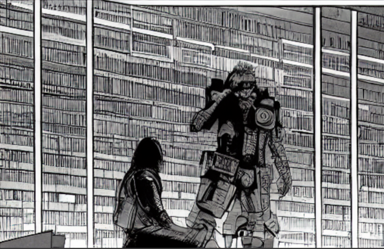

Interrogating with ViT-L/14...


,Model,Medium,Artist,Trending,Movement,Flavors
0,ViT-L/14,a comic book panel (46.6%),by Otomo Katsuhiro (14.9%),pixiv (19.2%),academic art (14.4%),"official art (9.1%), academic art (5.0%), sci-..."




a man standing next to a woman in front of a book shelf, a comic book panel by Otomo Katsuhiro, pixiv, academic art, official art, academic art, sci-fi


In [3]:

#@markdown After runing the above cell, paste the url of any image on the internet below and choose which AIs you want to show the image to we'll have it show us what it sees in the image.

#@markdown #####**Image:**

image_path_or_url = "/content/Library.png" #@param {type:"string"}

#@markdown 

#@markdown #####**CLIP models:**

#@markdown For [StableDiffusion](https://stability.ai/blog/stable-diffusion-announcement) you can just use ViTL14<br>
#@markdown For [DiscoDiffusion](https://colab.research.google.com/github/alembics/disco-diffusion/blob/main/Disco_Diffusion.ipynb) and 
#@markdown [JAX](https://colab.research.google.com/github/huemin-art/jax-guided-diffusion/blob/v2.7/Huemin_Jax_Diffusion_2_7.ipynb) choose your prefered models

ViTB32 = False #@param{type:"boolean"}
ViTB16 = False #@param{type:"boolean"}
ViTL14 = True #@param{type:"boolean"}
#ViTL14_336px = False #@param{type:"boolean"}
#RN101 = False #@param{type:"boolean"}
RN50 = False #@param{type:"boolean"}
#RN50x4 = False #@param{type:"boolean"}
#RN50x16 = False #@param{type:"boolean"}
#RN50x64 = False #@param{type:"boolean"}

models = []
if ViTB32: models.append('ViT-B/32')
if ViTB16: models.append('ViT-B/16')
if ViTL14: models.append('ViT-L/14')
#if ViTL14_336px: models.append('ViT-L/14@336px')
#if RN101: models.append('RN101')
if RN50: models.append('RN50')
#if RN50x4: models.append('RN50x4')
#if RN50x16: models.append('RN50x16')
#if RN50x64: models.append('RN50x64')

if str(image_path_or_url).startswith('http://') or str(image_path_or_url).startswith('https://'):
    image = Image.open(requests.get(image_path_or_url, stream=True).raw).convert('RGB')
else:
    image = Image.open(image_path_or_url).convert('RGB')

thumb = image.copy()
thumb.thumbnail([blip_image_eval_size, blip_image_eval_size])
display(thumb)

interrogate(image, models=models)


